In [19]:
#!/usr/bin/env python
# coding: utf-8

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import defaultdict


In [20]:

# Constants
IMG_SIZE = (320, 320)
BATCH_SIZE = 8
EPOCHS = 50
MURA_DATA_PATH = "../testML/MURA-v1.1"
MURA_TRAIN_PATH = MURA_DATA_PATH + "/train_labeled_studies.csv"
MURA_VALID_PATH = MURA_DATA_PATH + "/valid_labeled_studies.csv"

DS_DATA_PATH = "../dsTest"
DS_TRAIN_PATH = os.path.join(DS_DATA_PATH, "train")
DS_VALID_PATH = os.path.join(DS_DATA_PATH, "val")
DS_TEST_PATH = os.path.join(DS_DATA_PATH, "test")


In [21]:
# Load MURA Dataset
def load_mura_data(csv_path):
    """Load MURA dataset from CSV files"""
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "../testML"  # Root dataset directory
    
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        
        if os.path.exists(study_path):
            for image_file in os.listdir(study_path):
                image_path = os.path.join(study_path, image_file)
                if image_path.endswith(".png") and not image_file.startswith("._"):
                    image_paths.append(image_path)
                    labels.append(label)
        else:
            print(f"Warning: Study path does not exist: {study_path}")
    
    return np.array(image_paths), np.array(labels)


In [22]:
# Load Directory-based Dataset
def load_directory_data(base_path):
    """Load directory-based dataset (fractured/not fractured)"""
    image_paths = []
    labels = []
    class_names = {"not fractured": 0, "fractured": 1}
    
    if not os.path.exists(base_path):
        print(f"Warning: Directory does not exist: {base_path}")
        return np.array([]), np.array([])
    
    for label_name in class_names:
        folder_path = os.path.join(base_path, label_name)
        if os.path.exists(folder_path):
            for fname in os.listdir(folder_path):
                if fname.endswith((".png", ".jpg", ".jpeg")) and not fname.startswith("._"):
                    image_paths.append(os.path.join(folder_path, fname))
                    labels.append(class_names[label_name])
        else:
            print(f"Warning: Folder does not exist: {folder_path}")
    
    return np.array(image_paths), np.array(labels)


In [30]:
# Combined Data Loading Function
from sklearn.model_selection import train_test_split
import numpy as np

def load_combined_datasets(test_split=0.05, random_state=42):
    """Load and combine MURA and directory datasets, 
    split MURA train into train/test, and merge with DS"""
    
    print("Loading MURA dataset...")
    # Load MURA training and validation data
    mura_train_paths, mura_train_labels = load_mura_data(MURA_TRAIN_PATH)
    mura_valid_paths, mura_valid_labels = load_mura_data(MURA_VALID_PATH)

    # Split MURA train into new train and test
    mura_train_paths, mura_test_paths, mura_train_labels, mura_test_labels = train_test_split(
        mura_train_paths, mura_train_labels, test_size=test_split, random_state=random_state, stratify=mura_train_labels
    )

    print(f"MURA Train (split): {len(mura_train_paths)}")
    print(f"MURA Valid: {len(mura_valid_paths)}")
    print(f"MURA Test (from split): {len(mura_test_paths)}")
    
    print("Loading Directory dataset...")
    ds_train_paths, ds_train_labels = load_directory_data(DS_TRAIN_PATH)
    ds_valid_paths, ds_valid_labels = load_directory_data(DS_VALID_PATH)
    ds_test_paths, ds_test_labels = load_directory_data(DS_TEST_PATH)
    
    print(f"DS Train: {len(ds_train_paths)}")
    print(f"DS Valid: {len(ds_valid_paths)}")
    print(f"DS Test: {len(ds_test_paths)}")
    
    # Combine train
    combined_train_paths = np.concatenate([mura_train_paths, ds_train_paths])
    combined_train_labels = np.concatenate([mura_train_labels, ds_train_labels])
    
    # Combine validation
    combined_valid_paths = np.concatenate([mura_valid_paths, ds_valid_paths])
    combined_valid_labels = np.concatenate([mura_valid_labels, ds_valid_labels])
    
    # Combine test (MURA test from split + DS test)
    combined_test_paths = np.concatenate([mura_test_paths, ds_test_paths])
    combined_test_labels = np.concatenate([mura_test_labels, ds_test_labels])
    
    print("\n✅ Combined dataset sizes:")
    print(f"Train: {len(combined_train_paths)} images")
    print(f"Validation: {len(combined_valid_paths)} images")
    print(f"Test: {len(combined_test_paths)} images")
    
    return (combined_train_paths, combined_train_labels, 
            combined_valid_paths, combined_valid_labels,
            combined_test_paths, combined_test_labels)



In [31]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [32]:
class CombinedDataGenerator(Sequence):
    def __init__(self, image_paths, labels, class_weights, batch_size=BATCH_SIZE, 
                 img_size=IMG_SIZE, augment=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.class_weights = class_weights
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__data_generation(batch_paths, batch_labels)
        sample_weights = np.array([self.class_weights[label] for label in y])

        return X, y, sample_weights

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]
            self.labels = self.labels[indices]

    def __data_generation(self, batch_paths, batch_labels):
        images = []
        valid_labels = []
        
        for path, label in zip(batch_paths, batch_labels):
            try:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Could not read image {path}, skipping...")
                    continue
                
                img = cv2.resize(img, self.img_size)
                img = img / 255.0  # Normalize
                img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
                
                if self.augment and self.datagen:
                    img = self.datagen.random_transform(img)
                
                images.append(img)
                valid_labels.append(label)
                
            except Exception as e:
                print(f"Error processing image {path}: {e}")
                continue

        if len(images) == 0:
            # Return dummy batch if no valid images
            print("Warning: No valid images in batch, creating dummy batch")
            dummy_img = np.zeros((1, *self.img_size, 3))
            return dummy_img, np.array([0])

        return np.array(images), np.array(valid_labels)


In [ ]:
def create_model():
    """Create the DenseNet169 model"""
    # Load Pretrained Model
    base_model = DenseNet169(weights='imagenet', include_top=False, 
                           input_tensor=Input(shape=(*IMG_SIZE, 3)))
    
    # Gradually Unfreeze Layers (last 50 layers)
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    
    # Add Custom Classifier Head
    x = Flatten()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(units=128, activation='relu', kernel_initializer='he_normal', 
              kernel_regularizer=l2(0.02))(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    # Compile Model
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                 loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [33]:
def evaluate_model(model, test_generator, test_labels, threshold=0.5):
    """Evaluate model performance"""
    print(f"\nEvaluating model with threshold: {threshold}")
    pred = model.predict(test_generator)
    predictions = pred.flatten()
    predictions = (predictions > threshold).astype(int)
    
    y_test = np.array(test_labels).astype(int)
    predictions = np.array(predictions).astype(int)

    # Count correct and incorrect predictions
    true_positives = np.sum((predictions == 1) & (y_test == 1))
    true_negatives = np.sum((predictions == 0) & (y_test == 0))
    false_positives = np.sum((predictions == 1) & (y_test == 0))
    false_negatives = np.sum((predictions == 0) & (y_test == 1))

    print(f"True Positives: {true_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")

    # Calculate metrics
    accuracy = (true_positives + true_negatives) / len(y_test)
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    kappa = cohen_kappa_score(y_test, predictions)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")
    print(f"Cohen's Kappa: {kappa:.2f}")
    
    return accuracy, precision, recall, f1_score, kappa


In [ ]:
def plot_training_history(history_path):
    """Plot training history"""
    with open(history_path, "r") as file:
        history = json.load(file)

    epochs = range(1, len(history["accuracy"]) + 1)
    train_acc = history["accuracy"]
    val_acc = history["val_accuracy"]
    train_loss = history["loss"]
    val_loss = history["val_loss"]

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [34]:

"""Main training function"""
# Load combined datasets
(train_paths, train_labels, valid_paths, valid_labels, test_paths, test_labels) = load_combined_datasets()

if len(train_paths) == 0:
    print("Error: No training data found!")
    

# Calculate class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))
print(f"\nClass distribution in training data:")
unique, counts = np.unique(train_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
print("Class Weights:", class_weights)

# Create data generators
train_generator = CombinedDataGenerator(
    train_paths, train_labels,
    class_weights=class_weights,
    augment=True, shuffle=True
)

valid_generator = CombinedDataGenerator(
    valid_paths, valid_labels,
    class_weights=class_weights,
    augment=False, shuffle=False
)

test_generator = CombinedDataGenerator(
    test_paths, test_labels,
    class_weights=class_weights,
    augment=False, shuffle=False
)

Loading MURA dataset...
MURA Train (split): 34967
MURA Valid: 3197
MURA Test (from split): 1841
Loading Directory dataset...
DS Train: 9246
DS Valid: 829
DS Test: 506

✅ Combined dataset sizes:
Train: 44213 images
Validation: 4026 images
Test: 2347 images

Class distribution in training data:
Class 0: 25478 samples
Class 1: 18735 samples
Class Weights: {0: 0.8676701467933119, 1: 1.1799572991726714}


2025-06-02 12:38:51.392660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748857131.409325    7289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748857131.414835    7289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748857131.428349    7289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748857131.428371    7289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748857131.428373    7289 computation_placer.cc:177] computation placer alr

Loading MURA dataset...
MURA Train (split): 33127
MURA Valid: 3197
MURA Test (from split): 3681
Loading Directory dataset...
DS Train: 9246
DS Valid: 829
DS Test: 506

✅ Combined dataset sizes:
Train: 42373 images
Validation: 4026 images
Test: 4187 images

Class distribution in training data:
Class 0: 24381 samples
Class 1: 17992 samples
Class Weights: {0: 0.8689758418440588, 1: 1.177551133837261}


I0000 00:00:1748857134.585406    7289 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4362 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5



Model created with 34,607,937 parameters

Starting training for 50 epochs...


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 320, 320, 3))
  warnings.warn(msg)
I0000 00:00:1748857154.604167    7323 service.cc:152] XLA service 0x7aa978004af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748857154.604184    7323 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-06-02 12:39:15.171959: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748857158.743852    7323 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-06-02 12:39:20.768147: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.79GiB with freed_by_

 290/5297 ━━━━━━━━━━━━━━━━━━━━ 22:18 267ms/step - accuracy: 0.5495 - loss: 5.2954Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 291/5297 ━━━━━━━━━━━━━━━━━━━━ 22:19 268ms/step - accuracy: 0.5497 - loss: 5.2940

2025-06-02 12:41:07.058144: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-02 12:41:07.131301: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-02 12:41:07.785547: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-02 12:41:30.568788: I external/local_xla/xla/st

 924/5297 ━━━━━━━━━━━━━━━━━━━━ 21:36 297ms/step - accuracy: 0.5901 - loss: 4.8909

libpng warning: bKGD: invalid


1430/5297 ━━━━━━━━━━━━━━━━━━━━ 18:22 285ms/step - accuracy: 0.6008 - loss: 4.6793

2025-06-02 12:46:38.399611: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-02 12:46:57.980426: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_32', 8 bytes spill stores, 8 bytes spill loads



1761/5297 ━━━━━━━━━━━━━━━━━━━━ 17:22 295ms/step - accuracy: 0.6062 - loss: 4.5466

libpng warning: iCCP: known incorrect sRGB profile


1874/5297 ━━━━━━━━━━━━━━━━━━━━ 16:41 293ms/step - accuracy: 0.6079 - loss: 4.5033

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2019/5297 ━━━━━━━━━━━━━━━━━━━━ 15:52 291ms/step - accuracy: 0.6098 - loss: 4.4492Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2071/5297 ━━━━━━━━━━━━━━━━━━━━ 15:33 289ms/step - accuracy: 0.6105 - loss: 4.4303

libpng warning: iCCP: known incorrect sRGB profile


2439/5297 ━━━━━━━━━━━━━━━━━━━━ 13:40 287ms/step - accuracy: 0.6148 - loss: 4.3019

Premature end of JPEG file


2819/5297 ━━━━━━━━━━━━━━━━━━━━ 11:44 284ms/step - accuracy: 0.6187 - loss: 4.1795

Premature end of JPEG file


3084/5297 ━━━━━━━━━━━━━━━━━━━━ 10:25 282ms/step - accuracy: 0.6212 - loss: 4.1001

Premature end of JPEG file


3308/5297 ━━━━━━━━━━━━━━━━━━━━ 9:20 282ms/step - accuracy: 0.6233 - loss: 4.0365

libpng warning: iCCP: known incorrect sRGB profile


3332/5297 ━━━━━━━━━━━━━━━━━━━━ 9:12 281ms/step - accuracy: 0.6235 - loss: 4.0299

Premature end of JPEG file


4089/5297 ━━━━━━━━━━━━━━━━━━━━ 5:37 279ms/step - accuracy: 0.6295 - loss: 3.8365

libpng warning: bKGD: invalid


4175/5297 ━━━━━━━━━━━━━━━━━━━━ 5:13 279ms/step - accuracy: 0.6302 - loss: 3.8163

Premature end of JPEG file


4196/5297 ━━━━━━━━━━━━━━━━━━━━ 5:07 279ms/step - accuracy: 0.6303 - loss: 3.8115Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4251/5297 ━━━━━━━━━━━━━━━━━━━━ 4:51 279ms/step - accuracy: 0.6307 - loss: 3.7988

libpng warning: bKGD: invalid


4639/5297 ━━━━━━━━━━━━━━━━━━━━ 3:03 279ms/step - accuracy: 0.6333 - loss: 3.7134

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6374 - loss: 3.5817

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 1: val_loss improved from inf to 1.41885, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 1599s 293ms/step - accuracy: 0.6374 - loss: 3.5815 - val_accuracy: 0.7452 - val_loss: 1.4188 - learning_rate: 1.0000e-04
Epoch 2/50
  56/5297 ━━━━━━━━━━━━━━━━━━━━ 12:26 142ms/step - accuracy: 0.6730 - loss: 1.5839

Premature end of JPEG file


  83/5297 ━━━━━━━━━━━━━━━━━━━━ 12:22 142ms/step - accuracy: 0.6814 - loss: 1.5692

Premature end of JPEG file


  99/5297 ━━━━━━━━━━━━━━━━━━━━ 12:22 143ms/step - accuracy: 0.6859 - loss: 1.5621

Premature end of JPEG file


 425/5297 ━━━━━━━━━━━━━━━━━━━━ 11:35 143ms/step - accuracy: 0.7126 - loss: 1.5007

libpng warning: iCCP: known incorrect sRGB profile


 429/5297 ━━━━━━━━━━━━━━━━━━━━ 11:34 143ms/step - accuracy: 0.7127 - loss: 1.5005

libpng warning: bKGD: invalid


 835/5297 ━━━━━━━━━━━━━━━━━━━━ 10:33 142ms/step - accuracy: 0.7177 - loss: 1.4835

libpng warning: bKGD: invalid


1086/5297 ━━━━━━━━━━━━━━━━━━━━ 9:56 142ms/step - accuracy: 0.7189 - loss: 1.4748

libpng warning: bKGD: invalid


1133/5297 ━━━━━━━━━━━━━━━━━━━━ 9:50 142ms/step - accuracy: 0.7190 - loss: 1.4732

libpng warning: iCCP: known incorrect sRGB profile


1257/5297 ━━━━━━━━━━━━━━━━━━━━ 9:32 142ms/step - accuracy: 0.7192 - loss: 1.4687

Premature end of JPEG file


1645/5297 ━━━━━━━━━━━━━━━━━━━━ 8:36 142ms/step - accuracy: 0.7200 - loss: 1.4537Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1803/5297 ━━━━━━━━━━━━━━━━━━━━ 8:14 142ms/step - accuracy: 0.7204 - loss: 1.4476

libpng warning: iCCP: known incorrect sRGB profile


2889/5297 ━━━━━━━━━━━━━━━━━━━━ 5:40 141ms/step - accuracy: 0.7233 - loss: 1.4111Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3844/5297 ━━━━━━━━━━━━━━━━━━━━ 3:25 141ms/step - accuracy: 0.7253 - loss: 1.3823

Premature end of JPEG file


4605/5297 ━━━━━━━━━━━━━━━━━━━━ 1:37 141ms/step - accuracy: 0.7268 - loss: 1.3615

Premature end of JPEG file


5155/5297 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.7277 - loss: 1.3478Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
5215/5297 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.7278 - loss: 1.3463

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7279 - loss: 1.3444

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 2: val_loss improved from 1.41885 to 0.99114, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 790s 149ms/step - accuracy: 0.7279 - loss: 1.3443 - val_accuracy: 0.7737 - val_loss: 0.9911 - learning_rate: 1.0000e-04
Epoch 3/50
 202/5297 ━━━━━━━━━━━━━━━━━━━━ 12:00 141ms/step - accuracy: 0.7827 - loss: 0.9680Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 666/5297 ━━━━━━━━━━━━━━━━━━━━ 10:56 142ms/step - accuracy: 0.7686 - loss: 0.9996

Premature end of JPEG file


 703/5297 ━━━━━━━━━━━━━━━━━━━━ 10:51 142ms/step - accuracy: 0.7678 - loss: 1.0005

libpng warning: bKGD: invalid


1006/5297 ━━━━━━━━━━━━━━━━━━━━ 10:10 142ms/step - accuracy: 0.7627 - loss: 1.0054

libpng warning: iCCP: known incorrect sRGB profile


1103/5297 ━━━━━━━━━━━━━━━━━━━━ 9:56 142ms/step - accuracy: 0.7619 - loss: 1.0054

Premature end of JPEG file


1189/5297 ━━━━━━━━━━━━━━━━━━━━ 9:44 142ms/step - accuracy: 0.7613 - loss: 1.0052

Premature end of JPEG file


1424/5297 ━━━━━━━━━━━━━━━━━━━━ 9:10 142ms/step - accuracy: 0.7600 - loss: 1.0046

Premature end of JPEG file


1717/5297 ━━━━━━━━━━━━━━━━━━━━ 8:29 142ms/step - accuracy: 0.7587 - loss: 1.0030

libpng warning: iCCP: known incorrect sRGB profile


2337/5297 ━━━━━━━━━━━━━━━━━━━━ 7:00 142ms/step - accuracy: 0.7572 - loss: 0.9992Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3049/5297 ━━━━━━━━━━━━━━━━━━━━ 5:19 142ms/step - accuracy: 0.7566 - loss: 0.9931

libpng warning: bKGD: invalid


3100/5297 ━━━━━━━━━━━━━━━━━━━━ 5:11 142ms/step - accuracy: 0.7566 - loss: 0.9927Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3292/5297 ━━━━━━━━━━━━━━━━━━━━ 4:44 142ms/step - accuracy: 0.7565 - loss: 0.9910

libpng warning: bKGD: invalid


4484/5297 ━━━━━━━━━━━━━━━━━━━━ 1:55 142ms/step - accuracy: 0.7565 - loss: 0.9809

libpng warning: iCCP: known incorrect sRGB profile


4913/5297 ━━━━━━━━━━━━━━━━━━━━ 54s 142ms/step - accuracy: 0.7565 - loss: 0.9771

Premature end of JPEG file


5103/5297 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.7565 - loss: 0.9753

Premature end of JPEG file


5184/5297 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.7566 - loss: 0.9745

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7566 - loss: 0.9734

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 3: val_loss improved from 0.99114 to 0.78096, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 792s 150ms/step - accuracy: 0.7566 - loss: 0.9734 - val_accuracy: 0.7941 - val_loss: 0.7810 - learning_rate: 1.0000e-04
Epoch 4/50
 277/5297 ━━━━━━━━━━━━━━━━━━━━ 11:50 141ms/step - accuracy: 0.7735 - loss: 0.7947

Premature end of JPEG file


 434/5297 ━━━━━━━━━━━━━━━━━━━━ 11:30 142ms/step - accuracy: 0.7731 - loss: 0.7966

libpng warning: bKGD: invalid


2686/5297 ━━━━━━━━━━━━━━━━━━━━ 6:10 142ms/step - accuracy: 0.7763 - loss: 0.7860

Premature end of JPEG file


3140/5297 ━━━━━━━━━━━━━━━━━━━━ 5:05 142ms/step - accuracy: 0.7766 - loss: 0.7828Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3287/5297 ━━━━━━━━━━━━━━━━━━━━ 4:45 142ms/step - accuracy: 0.7767 - loss: 0.7818

libpng warning: bKGD: invalid


3513/5297 ━━━━━━━━━━━━━━━━━━━━ 4:13 142ms/step - accuracy: 0.7768 - loss: 0.7804

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3578/5297 ━━━━━━━━━━━━━━━━━━━━ 4:04 142ms/step - accuracy: 0.7768 - loss: 0.7799Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3594/5297 ━━━━━━━━━━━━━━━━━━━━ 4:02 142ms/step - accuracy: 0.7768 - loss: 0.7798

Premature end of JPEG file


3780/5297 ━━━━━━━━━━━━━━━━━━━━ 3:35 142ms/step - accuracy: 0.7770 - loss: 0.7786

Premature end of JPEG file


4063/5297 ━━━━━━━━━━━━━━━━━━━━ 2:55 142ms/step - accuracy: 0.7771 - loss: 0.7769

libpng warning: iCCP: known incorrect sRGB profile


4366/5297 ━━━━━━━━━━━━━━━━━━━━ 2:12 142ms/step - accuracy: 0.7773 - loss: 0.7751

Premature end of JPEG file


4476/5297 ━━━━━━━━━━━━━━━━━━━━ 1:56 142ms/step - accuracy: 0.7773 - loss: 0.7745

libpng warning: bKGD: invalid


4639/5297 ━━━━━━━━━━━━━━━━━━━━ 1:33 142ms/step - accuracy: 0.7774 - loss: 0.7735Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
4736/5297 ━━━━━━━━━━━━━━━━━━━━ 1:19 142ms/step - accuracy: 0.7774 - loss: 0.7730

Premature end of JPEG file


4763/5297 ━━━━━━━━━━━━━━━━━━━━ 1:16 142ms/step - accuracy: 0.7774 - loss: 0.7728

libpng warning: iCCP: known incorrect sRGB profile


5294/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7777 - loss: 0.7695

libpng warning: iCCP: known incorrect sRGB profile


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7777 - loss: 0.7694

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 4: val_loss improved from 0.78096 to 0.63834, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 795s 150ms/step - accuracy: 0.7777 - loss: 0.7694 - val_accuracy: 0.8045 - val_loss: 0.6383 - learning_rate: 1.0000e-04
Epoch 5/50
 625/5297 ━━━━━━━━━━━━━━━━━━━━ 10:58 141ms/step - accuracy: 0.7852 - loss: 0.6526

libpng warning: iCCP: known incorrect sRGB profile


 763/5297 ━━━━━━━━━━━━━━━━━━━━ 10:38 141ms/step - accuracy: 0.7861 - loss: 0.6531

Premature end of JPEG file


1030/5297 ━━━━━━━━━━━━━━━━━━━━ 9:59 141ms/step - accuracy: 0.7867 - loss: 0.6544Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1166/5297 ━━━━━━━━━━━━━━━━━━━━ 9:40 140ms/step - accuracy: 0.7870 - loss: 0.6548

Premature end of JPEG file


1619/5297 ━━━━━━━━━━━━━━━━━━━━ 8:35 140ms/step - accuracy: 0.7877 - loss: 0.6546

Premature end of JPEG file


2888/5297 ━━━━━━━━━━━━━━━━━━━━ 5:37 140ms/step - accuracy: 0.7894 - loss: 0.6519

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2936/5297 ━━━━━━━━━━━━━━━━━━━━ 5:31 140ms/step - accuracy: 0.7894 - loss: 0.6518Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3207/5297 ━━━━━━━━━━━━━━━━━━━━ 4:52 140ms/step - accuracy: 0.7895 - loss: 0.6513

libpng warning: bKGD: invalid


3309/5297 ━━━━━━━━━━━━━━━━━━━━ 4:38 140ms/step - accuracy: 0.7895 - loss: 0.6511

libpng warning: bKGD: invalid


3417/5297 ━━━━━━━━━━━━━━━━━━━━ 4:23 140ms/step - accuracy: 0.7896 - loss: 0.6509

libpng warning: iCCP: known incorrect sRGB profile


3591/5297 ━━━━━━━━━━━━━━━━━━━━ 3:59 141ms/step - accuracy: 0.7896 - loss: 0.6506Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3599/5297 ━━━━━━━━━━━━━━━━━━━━ 3:58 141ms/step - accuracy: 0.7896 - loss: 0.6506

libpng warning: iCCP: known incorrect sRGB profile


3760/5297 ━━━━━━━━━━━━━━━━━━━━ 3:36 141ms/step - accuracy: 0.7897 - loss: 0.6504

libpng warning: bKGD: invalid


3846/5297 ━━━━━━━━━━━━━━━━━━━━ 3:24 141ms/step - accuracy: 0.7897 - loss: 0.6502

Premature end of JPEG file


4121/5297 ━━━━━━━━━━━━━━━━━━━━ 2:46 142ms/step - accuracy: 0.7898 - loss: 0.6497

Premature end of JPEG file


4908/5297 ━━━━━━━━━━━━━━━━━━━━ 55s 143ms/step - accuracy: 0.7900 - loss: 0.6482

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7901 - loss: 0.6473

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 5: val_loss did not improve from 0.63834
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 792s 150ms/step - accuracy: 0.7901 - loss: 0.6473 - val_accuracy: 0.7943 - val_loss: 0.6489 - learning_rate: 1.0000e-04
Epoch 6/50
 472/5297 ━━━━━━━━━━━━━━━━━━━━ 11:59 149ms/step - accuracy: 0.7936 - loss: 0.6222

libpng warning: iCCP: known incorrect sRGB profile


 808/5297 ━━━━━━━━━━━━━━━━━━━━ 11:10 149ms/step - accuracy: 0.7934 - loss: 0.6171

libpng warning: bKGD: invalid


1041/5297 ━━━━━━━━━━━━━━━━━━━━ 10:34 149ms/step - accuracy: 0.7940 - loss: 0.6154

Premature end of JPEG file


1462/5297 ━━━━━━━━━━━━━━━━━━━━ 9:31 149ms/step - accuracy: 0.7940 - loss: 0.6145

libpng warning: iCCP: known incorrect sRGB profile


1651/5297 ━━━━━━━━━━━━━━━━━━━━ 9:02 149ms/step - accuracy: 0.7941 - loss: 0.6140

Premature end of JPEG file


2635/5297 ━━━━━━━━━━━━━━━━━━━━ 6:36 149ms/step - accuracy: 0.7952 - loss: 0.6100

Premature end of JPEG file


2695/5297 ━━━━━━━━━━━━━━━━━━━━ 6:27 149ms/step - accuracy: 0.7953 - loss: 0.6098

Premature end of JPEG file


2741/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 149ms/step - accuracy: 0.7953 - loss: 0.6096

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3332/5297 ━━━━━━━━━━━━━━━━━━━━ 4:52 149ms/step - accuracy: 0.7960 - loss: 0.6078

libpng warning: bKGD: invalid


3449/5297 ━━━━━━━━━━━━━━━━━━━━ 4:35 149ms/step - accuracy: 0.7960 - loss: 0.6076

Premature end of JPEG file


3458/5297 ━━━━━━━━━━━━━━━━━━━━ 4:33 149ms/step - accuracy: 0.7961 - loss: 0.6075

libpng warning: iCCP: known incorrect sRGB profile


3484/5297 ━━━━━━━━━━━━━━━━━━━━ 4:29 149ms/step - accuracy: 0.7961 - loss: 0.6075Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3953/5297 ━━━━━━━━━━━━━━━━━━━━ 3:20 149ms/step - accuracy: 0.7964 - loss: 0.6065Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
4126/5297 ━━━━━━━━━━━━━━━━━━━━ 2:54 149ms/step - accuracy: 0.7965 - loss: 0.6062

libpng warning: bKGD: invalid


4781/5297 ━━━━━━━━━━━━━━━━━━━━ 1:16 149ms/step - accuracy: 0.7969 - loss: 0.6051

Premature end of JPEG file


5142/5297 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7971 - loss: 0.6046Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7972 - loss: 0.6044

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 6: val_loss improved from 0.63834 to 0.56488, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 829s 157ms/step - accuracy: 0.7972 - loss: 0.6044 - val_accuracy: 0.8231 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 7/50
  94/5297 ━━━━━━━━━━━━━━━━━━━━ 12:13 141ms/step - accuracy: 0.8212 - loss: 0.5866

Premature end of JPEG file


 443/5297 ━━━━━━━━━━━━━━━━━━━━ 11:42 145ms/step - accuracy: 0.8103 - loss: 0.5891

Premature end of JPEG file


 453/5297 ━━━━━━━━━━━━━━━━━━━━ 11:41 145ms/step - accuracy: 0.8102 - loss: 0.5891

libpng warning: iCCP: known incorrect sRGB profile


 573/5297 ━━━━━━━━━━━━━━━━━━━━ 11:21 144ms/step - accuracy: 0.8092 - loss: 0.5882

Premature end of JPEG file


 672/5297 ━━━━━━━━━━━━━━━━━━━━ 11:06 144ms/step - accuracy: 0.8089 - loss: 0.5873

Premature end of JPEG file


 883/5297 ━━━━━━━━━━━━━━━━━━━━ 10:34 144ms/step - accuracy: 0.8084 - loss: 0.5866

Premature end of JPEG file


1378/5297 ━━━━━━━━━━━━━━━━━━━━ 9:21 143ms/step - accuracy: 0.8089 - loss: 0.5845

libpng warning: iCCP: known incorrect sRGB profile


2669/5297 ━━━━━━━━━━━━━━━━━━━━ 6:14 143ms/step - accuracy: 0.8084 - loss: 0.5849Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3418/5297 ━━━━━━━━━━━━━━━━━━━━ 4:27 142ms/step - accuracy: 0.8082 - loss: 0.5847

libpng warning: bKGD: invalid


3665/5297 ━━━━━━━━━━━━━━━━━━━━ 3:52 142ms/step - accuracy: 0.8081 - loss: 0.5847

libpng warning: bKGD: invalid


4331/5297 ━━━━━━━━━━━━━━━━━━━━ 2:17 142ms/step - accuracy: 0.8079 - loss: 0.5845Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4624/5297 ━━━━━━━━━━━━━━━━━━━━ 1:35 142ms/step - accuracy: 0.8079 - loss: 0.5845

libpng warning: iCCP: known incorrect sRGB profile


4777/5297 ━━━━━━━━━━━━━━━━━━━━ 1:13 142ms/step - accuracy: 0.8079 - loss: 0.5845Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
4845/5297 ━━━━━━━━━━━━━━━━━━━━ 1:04 142ms/step - accuracy: 0.8079 - loss: 0.5845

Premature end of JPEG file


5018/5297 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.8079 - loss: 0.5845

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5122/5297 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.8078 - loss: 0.5845

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8078 - loss: 0.5845

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 7: val_loss did not improve from 0.56488
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 788s 149ms/step - accuracy: 0.8078 - loss: 0.5845 - val_accuracy: 0.8122 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 8/50
  44/5297 ━━━━━━━━━━━━━━━━━━━━ 12:30 143ms/step - accuracy: 0.8100 - loss: 0.5457

Premature end of JPEG file


 483/5297 ━━━━━━━━━━━━━━━━━━━━ 11:28 143ms/step - accuracy: 0.8169 - loss: 0.5562

Premature end of JPEG file


 789/5297 ━━━━━━━━━━━━━━━━━━━━ 10:41 142ms/step - accuracy: 0.8176 - loss: 0.5585Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 823/5297 ━━━━━━━━━━━━━━━━━━━━ 10:37 142ms/step - accuracy: 0.8176 - loss: 0.5589

libpng warning: iCCP: known incorrect sRGB profile


 912/5297 ━━━━━━━━━━━━━━━━━━━━ 10:23 142ms/step - accuracy: 0.8175 - loss: 0.5599

libpng warning: bKGD: invalid


1564/5297 ━━━━━━━━━━━━━━━━━━━━ 8:49 142ms/step - accuracy: 0.8159 - loss: 0.5647

Premature end of JPEG file


1624/5297 ━━━━━━━━━━━━━━━━━━━━ 8:41 142ms/step - accuracy: 0.8157 - loss: 0.5650

Premature end of JPEG file


1833/5297 ━━━━━━━━━━━━━━━━━━━━ 8:11 142ms/step - accuracy: 0.8152 - loss: 0.5661

libpng warning: iCCP: known incorrect sRGB profile


2419/5297 ━━━━━━━━━━━━━━━━━━━━ 6:48 142ms/step - accuracy: 0.8141 - loss: 0.5682Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2909/5297 ━━━━━━━━━━━━━━━━━━━━ 5:38 142ms/step - accuracy: 0.8136 - loss: 0.5692

Premature end of JPEG file


2990/5297 ━━━━━━━━━━━━━━━━━━━━ 5:27 142ms/step - accuracy: 0.8136 - loss: 0.5693

libpng warning: bKGD: invalid


4450/5297 ━━━━━━━━━━━━━━━━━━━━ 2:00 142ms/step - accuracy: 0.8132 - loss: 0.5701Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4456/5297 ━━━━━━━━━━━━━━━━━━━━ 1:59 142ms/step - accuracy: 0.8132 - loss: 0.5701

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


4519/5297 ━━━━━━━━━━━━━━━━━━━━ 1:50 142ms/step - accuracy: 0.8132 - loss: 0.5701

Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile


4700/5297 ━━━━━━━━━━━━━━━━━━━━ 1:24 142ms/step - accuracy: 0.8131 - loss: 0.5702

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8129 - loss: 0.5703

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 8: val_loss improved from 0.56488 to 0.56404, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 792s 149ms/step - accuracy: 0.8129 - loss: 0.5703 - val_accuracy: 0.8231 - val_loss: 0.5640 - learning_rate: 1.0000e-04
Epoch 9/50
 235/5297 ━━━━━━━━━━━━━━━━━━━━ 12:07 144ms/step - accuracy: 0.8161 - loss: 0.5629

libpng warning: iCCP: known incorrect sRGB profile


 571/5297 ━━━━━━━━━━━━━━━━━━━━ 11:13 142ms/step - accuracy: 0.8173 - loss: 0.5579

libpng warning: bKGD: invalid


1383/5297 ━━━━━━━━━━━━━━━━━━━━ 9:13 141ms/step - accuracy: 0.8162 - loss: 0.5568Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2527/5297 ━━━━━━━━━━━━━━━━━━━━ 6:30 141ms/step - accuracy: 0.8166 - loss: 0.5568

Premature end of JPEG file


2569/5297 ━━━━━━━━━━━━━━━━━━━━ 6:24 141ms/step - accuracy: 0.8166 - loss: 0.5569Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2577/5297 ━━━━━━━━━━━━━━━━━━━━ 6:23 141ms/step - accuracy: 0.8166 - loss: 0.5569Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2597/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 141ms/step - accuracy: 0.8166 - loss: 0.5569

Premature end of JPEG file


3217/5297 ━━━━━━━━━━━━━━━━━━━━ 4:53 141ms/step - accuracy: 0.8164 - loss: 0.5576

Premature end of JPEG file


3331/5297 ━━━━━━━━━━━━━━━━━━━━ 4:37 141ms/step - accuracy: 0.8164 - loss: 0.5577

libpng warning: bKGD: invalid


3667/5297 ━━━━━━━━━━━━━━━━━━━━ 3:49 141ms/step - accuracy: 0.8162 - loss: 0.5579

libpng warning: iCCP: known incorrect sRGB profile


3821/5297 ━━━━━━━━━━━━━━━━━━━━ 3:28 141ms/step - accuracy: 0.8162 - loss: 0.5580

Premature end of JPEG file


3848/5297 ━━━━━━━━━━━━━━━━━━━━ 3:24 141ms/step - accuracy: 0.8162 - loss: 0.5581

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3950/5297 ━━━━━━━━━━━━━━━━━━━━ 3:09 141ms/step - accuracy: 0.8161 - loss: 0.5581

Premature end of JPEG file


4907/5297 ━━━━━━━━━━━━━━━━━━━━ 54s 141ms/step - accuracy: 0.8157 - loss: 0.5587

libpng warning: bKGD: invalid


5132/5297 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.8156 - loss: 0.5588

Premature end of JPEG file


5139/5297 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.8156 - loss: 0.5588

libpng warning: iCCP: known incorrect sRGB profile


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8156 - loss: 0.5589

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 9: val_loss did not improve from 0.56404
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 781s 147ms/step - accuracy: 0.8156 - loss: 0.5589 - val_accuracy: 0.8110 - val_loss: 0.5664 - learning_rate: 1.0000e-04
Epoch 10/50
  59/5297 ━━━━━━━━━━━━━━━━━━━━ 12:59 149ms/step - accuracy: 0.8034 - loss: 0.5988

Premature end of JPEG file


 550/5297 ━━━━━━━━━━━━━━━━━━━━ 11:49 149ms/step - accuracy: 0.8142 - loss: 0.5573

Premature end of JPEG file


 728/5297 ━━━━━━━━━━━━━━━━━━━━ 11:23 150ms/step - accuracy: 0.8151 - loss: 0.5554

libpng warning: iCCP: known incorrect sRGB profile


 783/5297 ━━━━━━━━━━━━━━━━━━━━ 11:15 150ms/step - accuracy: 0.8153 - loss: 0.5549

Premature end of JPEG file


 930/5297 ━━━━━━━━━━━━━━━━━━━━ 10:53 150ms/step - accuracy: 0.8158 - loss: 0.5537

libpng warning: bKGD: invalid


1001/5297 ━━━━━━━━━━━━━━━━━━━━ 10:43 150ms/step - accuracy: 0.8158 - loss: 0.5533Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1236/5297 ━━━━━━━━━━━━━━━━━━━━ 10:08 150ms/step - accuracy: 0.8160 - loss: 0.5527

Premature end of JPEG file


1474/5297 ━━━━━━━━━━━━━━━━━━━━ 9:32 150ms/step - accuracy: 0.8160 - loss: 0.5528

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1498/5297 ━━━━━━━━━━━━━━━━━━━━ 9:29 150ms/step - accuracy: 0.8160 - loss: 0.5528

libpng warning: bKGD: invalid


2564/5297 ━━━━━━━━━━━━━━━━━━━━ 6:48 150ms/step - accuracy: 0.8167 - loss: 0.5535

Premature end of JPEG file


2605/5297 ━━━━━━━━━━━━━━━━━━━━ 6:42 150ms/step - accuracy: 0.8167 - loss: 0.5535Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3044/5297 ━━━━━━━━━━━━━━━━━━━━ 5:37 150ms/step - accuracy: 0.8168 - loss: 0.5540

libpng warning: iCCP: known incorrect sRGB profile


4029/5297 ━━━━━━━━━━━━━━━━━━━━ 3:10 150ms/step - accuracy: 0.8168 - loss: 0.5550

Premature end of JPEG file


4570/5297 ━━━━━━━━━━━━━━━━━━━━ 1:49 150ms/step - accuracy: 0.8169 - loss: 0.5551

libpng warning: bKGD: invalid


4665/5297 ━━━━━━━━━━━━━━━━━━━━ 1:34 150ms/step - accuracy: 0.8169 - loss: 0.5551

libpng warning: iCCP: known incorrect sRGB profile


5047/5297 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.8171 - loss: 0.5551Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8171 - loss: 0.5551

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 10: val_loss improved from 0.56404 to 0.53014, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 836s 158ms/step - accuracy: 0.8171 - loss: 0.5551 - val_accuracy: 0.8323 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 11/50
 798/5297 ━━━━━━━━━━━━━━━━━━━━ 10:36 141ms/step - accuracy: 0.8204 - loss: 0.5354

Premature end of JPEG file


1034/5297 ━━━━━━━━━━━━━━━━━━━━ 10:03 142ms/step - accuracy: 0.8207 - loss: 0.5373

Premature end of JPEG file


1148/5297 ━━━━━━━━━━━━━━━━━━━━ 9:47 142ms/step - accuracy: 0.8208 - loss: 0.5382

libpng warning: iCCP: known incorrect sRGB profile


1149/5297 ━━━━━━━━━━━━━━━━━━━━ 9:47 142ms/step - accuracy: 0.8208 - loss: 0.5382Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1347/5297 ━━━━━━━━━━━━━━━━━━━━ 9:20 142ms/step - accuracy: 0.8210 - loss: 0.5396

libpng warning: bKGD: invalid


1719/5297 ━━━━━━━━━━━━━━━━━━━━ 8:27 142ms/step - accuracy: 0.8209 - loss: 0.5416

libpng warning: bKGD: invalid


1732/5297 ━━━━━━━━━━━━━━━━━━━━ 8:25 142ms/step - accuracy: 0.8209 - loss: 0.5417

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1861/5297 ━━━━━━━━━━━━━━━━━━━━ 8:07 142ms/step - accuracy: 0.8207 - loss: 0.5423

Premature end of JPEG file


1924/5297 ━━━━━━━━━━━━━━━━━━━━ 7:58 142ms/step - accuracy: 0.8206 - loss: 0.5426Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1999/5297 ━━━━━━━━━━━━━━━━━━━━ 7:48 142ms/step - accuracy: 0.8206 - loss: 0.5429

Premature end of JPEG file


2414/5297 ━━━━━━━━━━━━━━━━━━━━ 6:49 142ms/step - accuracy: 0.8204 - loss: 0.5440

libpng warning: iCCP: known incorrect sRGB profile


2419/5297 ━━━━━━━━━━━━━━━━━━━━ 6:48 142ms/step - accuracy: 0.8204 - loss: 0.5441

Premature end of JPEG file


2943/5297 ━━━━━━━━━━━━━━━━━━━━ 5:34 142ms/step - accuracy: 0.8205 - loss: 0.5452

libpng warning: bKGD: invalid


3490/5297 ━━━━━━━━━━━━━━━━━━━━ 4:16 142ms/step - accuracy: 0.8203 - loss: 0.5462

libpng warning: iCCP: known incorrect sRGB profile


3499/5297 ━━━━━━━━━━━━━━━━━━━━ 4:15 142ms/step - accuracy: 0.8203 - loss: 0.5462Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
5262/5297 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.8199 - loss: 0.5483

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8199 - loss: 0.5484

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 11: val_loss did not improve from 0.53014
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 796s 150ms/step - accuracy: 0.8199 - loss: 0.5484 - val_accuracy: 0.8231 - val_loss: 0.5544 - learning_rate: 1.0000e-04
Epoch 12/50
 231/5297 ━━━━━━━━━━━━━━━━━━━━ 11:52 141ms/step - accuracy: 0.8098 - loss: 0.5705

Premature end of JPEG file


 358/5297 ━━━━━━━━━━━━━━━━━━━━ 11:36 141ms/step - accuracy: 0.8155 - loss: 0.5580

libpng warning: bKGD: invalid


 726/5297 ━━━━━━━━━━━━━━━━━━━━ 10:45 141ms/step - accuracy: 0.8165 - loss: 0.5536

Premature end of JPEG file


1478/5297 ━━━━━━━━━━━━━━━━━━━━ 8:59 141ms/step - accuracy: 0.8168 - loss: 0.5491

libpng warning: iCCP: known incorrect sRGB profile


1623/5297 ━━━━━━━━━━━━━━━━━━━━ 8:39 141ms/step - accuracy: 0.8167 - loss: 0.5488

libpng warning: iCCP: known incorrect sRGB profile


1783/5297 ━━━━━━━━━━━━━━━━━━━━ 8:16 141ms/step - accuracy: 0.8167 - loss: 0.5485Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1953/5297 ━━━━━━━━━━━━━━━━━━━━ 7:52 141ms/step - accuracy: 0.8167 - loss: 0.5483

Premature end of JPEG file


2286/5297 ━━━━━━━━━━━━━━━━━━━━ 7:04 141ms/step - accuracy: 0.8167 - loss: 0.5483

libpng warning: bKGD: invalid


2447/5297 ━━━━━━━━━━━━━━━━━━━━ 6:41 141ms/step - accuracy: 0.8167 - loss: 0.5482

Premature end of JPEG file


2754/5297 ━━━━━━━━━━━━━━━━━━━━ 5:58 141ms/step - accuracy: 0.8167 - loss: 0.5481

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2851/5297 ━━━━━━━━━━━━━━━━━━━━ 5:44 141ms/step - accuracy: 0.8167 - loss: 0.5482

libpng warning: iCCP: known incorrect sRGB profile


2985/5297 ━━━━━━━━━━━━━━━━━━━━ 5:26 141ms/step - accuracy: 0.8166 - loss: 0.5483

Premature end of JPEG file


3253/5297 ━━━━━━━━━━━━━━━━━━━━ 4:48 141ms/step - accuracy: 0.8166 - loss: 0.5484Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3270/5297 ━━━━━━━━━━━━━━━━━━━━ 4:46 141ms/step - accuracy: 0.8166 - loss: 0.5484Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3571/5297 ━━━━━━━━━━━━━━━━━━━━ 4:03 141ms/step - accuracy: 0.8167 - loss: 0.5485

libpng warning: bKGD: invalid


3894/5297 ━━━━━━━━━━━━━━━━━━━━ 3:17 141ms/step - accuracy: 0.8167 - loss: 0.5486

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8172 - loss: 0.5482

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 12: val_loss did not improve from 0.53014
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 780s 147ms/step - accuracy: 0.8172 - loss: 0.5482 - val_accuracy: 0.8199 - val_loss: 0.5766 - learning_rate: 1.0000e-04
Epoch 13/50
 238/5297 ━━━━━━━━━━━━━━━━━━━━ 11:59 142ms/step - accuracy: 0.8215 - loss: 0.5445

Premature end of JPEG file


 564/5297 ━━━━━━━━━━━━━━━━━━━━ 11:13 142ms/step - accuracy: 0.8220 - loss: 0.5472Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 773/5297 ━━━━━━━━━━━━━━━━━━━━ 10:42 142ms/step - accuracy: 0.8219 - loss: 0.5476

libpng warning: bKGD: invalid


1278/5297 ━━━━━━━━━━━━━━━━━━━━ 9:30 142ms/step - accuracy: 0.8225 - loss: 0.5458

libpng warning: iCCP: known incorrect sRGB profile


1300/5297 ━━━━━━━━━━━━━━━━━━━━ 9:27 142ms/step - accuracy: 0.8226 - loss: 0.5458

Premature end of JPEG file


2097/5297 ━━━━━━━━━━━━━━━━━━━━ 7:34 142ms/step - accuracy: 0.8227 - loss: 0.5454

libpng warning: bKGD: invalid


2112/5297 ━━━━━━━━━━━━━━━━━━━━ 7:32 142ms/step - accuracy: 0.8227 - loss: 0.5454

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2615/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 142ms/step - accuracy: 0.8230 - loss: 0.5448Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2666/5297 ━━━━━━━━━━━━━━━━━━━━ 6:13 142ms/step - accuracy: 0.8230 - loss: 0.5448

libpng warning: iCCP: known incorrect sRGB profile


2708/5297 ━━━━━━━━━━━━━━━━━━━━ 6:08 142ms/step - accuracy: 0.8230 - loss: 0.5447

Premature end of JPEG file


3629/5297 ━━━━━━━━━━━━━━━━━━━━ 3:59 144ms/step - accuracy: 0.8231 - loss: 0.5438

libpng warning: iCCP: known incorrect sRGB profile


4253/5297 ━━━━━━━━━━━━━━━━━━━━ 2:30 144ms/step - accuracy: 0.8229 - loss: 0.5435

libpng warning: bKGD: invalid


4641/5297 ━━━━━━━━━━━━━━━━━━━━ 1:34 145ms/step - accuracy: 0.8228 - loss: 0.5434

Premature end of JPEG file


4806/5297 ━━━━━━━━━━━━━━━━━━━━ 1:11 145ms/step - accuracy: 0.8228 - loss: 0.5433Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4828/5297 ━━━━━━━━━━━━━━━━━━━━ 1:07 145ms/step - accuracy: 0.8228 - loss: 0.5433

Premature end of JPEG file


5045/5297 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.8228 - loss: 0.5433

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8227 - loss: 0.5433

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 13: val_loss did not improve from 0.53014
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 801s 151ms/step - accuracy: 0.8227 - loss: 0.5433 - val_accuracy: 0.8358 - val_loss: 0.5317 - learning_rate: 1.0000e-04
Epoch 14/50
 265/5297 ━━━━━━━━━━━━━━━━━━━━ 11:46 140ms/step - accuracy: 0.8216 - loss: 0.5523

libpng warning: bKGD: invalid


 584/5297 ━━━━━━━━━━━━━━━━━━━━ 10:59 140ms/step - accuracy: 0.8289 - loss: 0.5300Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 972/5297 ━━━━━━━━━━━━━━━━━━━━ 10:05 140ms/step - accuracy: 0.8332 - loss: 0.5131Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 994/5297 ━━━━━━━━━━━━━━━━━━━━ 10:02 140ms/step - accuracy: 0.8334 - loss: 0.5124Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1365/5297 ━━━━━━━━━━━━━━━━━━━━ 9:10 140ms/step - accuracy: 0.8353 - loss: 0.5027

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1904/5297 ━━━━━━━━━━━━━━━━━━━━ 7:55 140ms/step - accuracy: 0.8356 - loss: 0.4946

Premature end of JPEG file


2352/5297 ━━━━━━━━━━━━━━━━━━━━ 6:52 140ms/step - accuracy: 0.8358 - loss: 0.4902

Premature end of JPEG file


2612/5297 ━━━━━━━━━━━━━━━━━━━━ 6:16 140ms/step - accuracy: 0.8359 - loss: 0.4884

Premature end of JPEG file


3027/5297 ━━━━━━━━━━━━━━━━━━━━ 5:17 140ms/step - accuracy: 0.8360 - loss: 0.4859

Premature end of JPEG file


3421/5297 ━━━━━━━━━━━━━━━━━━━━ 4:22 140ms/step - accuracy: 0.8361 - loss: 0.4840

libpng warning: bKGD: invalid


3767/5297 ━━━━━━━━━━━━━━━━━━━━ 3:34 140ms/step - accuracy: 0.8362 - loss: 0.4825

libpng warning: iCCP: known incorrect sRGB profile


4350/5297 ━━━━━━━━━━━━━━━━━━━━ 2:12 140ms/step - accuracy: 0.8363 - loss: 0.4805

libpng warning: iCCP: known incorrect sRGB profile


4569/5297 ━━━━━━━━━━━━━━━━━━━━ 1:42 140ms/step - accuracy: 0.8363 - loss: 0.4799

Premature end of JPEG file


4673/5297 ━━━━━━━━━━━━━━━━━━━━ 1:27 140ms/step - accuracy: 0.8363 - loss: 0.4797

libpng warning: iCCP: known incorrect sRGB profile


4787/5297 ━━━━━━━━━━━━━━━━━━━━ 1:11 140ms/step - accuracy: 0.8363 - loss: 0.4794

Premature end of JPEG file


5110/5297 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.8363 - loss: 0.4787

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8364 - loss: 0.4783

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 14: val_loss improved from 0.53014 to 0.47477, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 784s 148ms/step - accuracy: 0.8364 - loss: 0.4783 - val_accuracy: 0.8383 - val_loss: 0.4748 - learning_rate: 5.0000e-05
Epoch 15/50
 215/5297 ━━━━━━━━━━━━━━━━━━━━ 11:52 140ms/step - accuracy: 0.8670 - loss: 0.4583

Premature end of JPEG file


 612/5297 ━━━━━━━━━━━━━━━━━━━━ 10:54 140ms/step - accuracy: 0.8544 - loss: 0.4672

libpng warning: bKGD: invalid


 783/5297 ━━━━━━━━━━━━━━━━━━━━ 10:30 140ms/step - accuracy: 0.8521 - loss: 0.4681

Premature end of JPEG file


1038/5297 ━━━━━━━━━━━━━━━━━━━━ 9:54 140ms/step - accuracy: 0.8506 - loss: 0.4676Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1107/5297 ━━━━━━━━━━━━━━━━━━━━ 9:45 140ms/step - accuracy: 0.8503 - loss: 0.4673

Premature end of JPEG file


1428/5297 ━━━━━━━━━━━━━━━━━━━━ 8:59 140ms/step - accuracy: 0.8487 - loss: 0.4673

Premature end of JPEG file


1704/5297 ━━━━━━━━━━━━━━━━━━━━ 8:21 140ms/step - accuracy: 0.8477 - loss: 0.4671

libpng warning: iCCP: known incorrect sRGB profile


1825/5297 ━━━━━━━━━━━━━━━━━━━━ 8:04 140ms/step - accuracy: 0.8474 - loss: 0.4670

Premature end of JPEG file


2295/5297 ━━━━━━━━━━━━━━━━━━━━ 6:59 140ms/step - accuracy: 0.8463 - loss: 0.4665

Premature end of JPEG file


2667/5297 ━━━━━━━━━━━━━━━━━━━━ 6:07 140ms/step - accuracy: 0.8457 - loss: 0.4663

libpng warning: bKGD: invalid


2833/5297 ━━━━━━━━━━━━━━━━━━━━ 5:44 140ms/step - accuracy: 0.8454 - loss: 0.4663Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3105/5297 ━━━━━━━━━━━━━━━━━━━━ 5:06 140ms/step - accuracy: 0.8451 - loss: 0.4663Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3866/5297 ━━━━━━━━━━━━━━━━━━━━ 3:20 140ms/step - accuracy: 0.8445 - loss: 0.4659

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3897/5297 ━━━━━━━━━━━━━━━━━━━━ 3:15 140ms/step - accuracy: 0.8445 - loss: 0.4659

libpng warning: iCCP: known incorrect sRGB profile


4082/5297 ━━━━━━━━━━━━━━━━━━━━ 2:49 140ms/step - accuracy: 0.8443 - loss: 0.4659

libpng warning: iCCP: known incorrect sRGB profile


4582/5297 ━━━━━━━━━━━━━━━━━━━━ 1:39 140ms/step - accuracy: 0.8440 - loss: 0.4658

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8436 - loss: 0.4657

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 15: val_loss did not improve from 0.47477
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 774s 146ms/step - accuracy: 0.8436 - loss: 0.4657 - val_accuracy: 0.8363 - val_loss: 0.4990 - learning_rate: 5.0000e-05
Epoch 16/50
 319/5297 ━━━━━━━━━━━━━━━━━━━━ 11:41 141ms/step - accuracy: 0.8426 - loss: 0.4605

libpng warning: bKGD: invalid


 325/5297 ━━━━━━━━━━━━━━━━━━━━ 11:41 141ms/step - accuracy: 0.8425 - loss: 0.4605

libpng warning: bKGD: invalid


 335/5297 ━━━━━━━━━━━━━━━━━━━━ 11:39 141ms/step - accuracy: 0.8424 - loss: 0.4605Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 457/5297 ━━━━━━━━━━━━━━━━━━━━ 11:22 141ms/step - accuracy: 0.8427 - loss: 0.4597

Premature end of JPEG file


 651/5297 ━━━━━━━━━━━━━━━━━━━━ 10:55 141ms/step - accuracy: 0.8434 - loss: 0.4584

Premature end of JPEG file


1192/5297 ━━━━━━━━━━━━━━━━━━━━ 9:38 141ms/step - accuracy: 0.8431 - loss: 0.4595

Premature end of JPEG file


1682/5297 ━━━━━━━━━━━━━━━━━━━━ 8:29 141ms/step - accuracy: 0.8428 - loss: 0.4609

Premature end of JPEG file


1874/5297 ━━━━━━━━━━━━━━━━━━━━ 8:02 141ms/step - accuracy: 0.8429 - loss: 0.4611

libpng warning: bKGD: invalid


2344/5297 ━━━━━━━━━━━━━━━━━━━━ 6:55 141ms/step - accuracy: 0.8431 - loss: 0.4613Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2774/5297 ━━━━━━━━━━━━━━━━━━━━ 5:56 141ms/step - accuracy: 0.8432 - loss: 0.4615Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2901/5297 ━━━━━━━━━━━━━━━━━━━━ 5:38 141ms/step - accuracy: 0.8432 - loss: 0.4615

libpng warning: iCCP: known incorrect sRGB profile


3601/5297 ━━━━━━━━━━━━━━━━━━━━ 3:59 141ms/step - accuracy: 0.8433 - loss: 0.4618

libpng warning: iCCP: known incorrect sRGB profile


3854/5297 ━━━━━━━━━━━━━━━━━━━━ 3:23 141ms/step - accuracy: 0.8432 - loss: 0.4619

libpng warning: iCCP: known incorrect sRGB profile


4211/5297 ━━━━━━━━━━━━━━━━━━━━ 2:33 141ms/step - accuracy: 0.8432 - loss: 0.4620

Premature end of JPEG file


4255/5297 ━━━━━━━━━━━━━━━━━━━━ 2:26 141ms/step - accuracy: 0.8432 - loss: 0.4620

Premature end of JPEG file


4630/5297 ━━━━━━━━━━━━━━━━━━━━ 1:34 141ms/step - accuracy: 0.8432 - loss: 0.4621

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8432 - loss: 0.4622

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 16: val_loss did not improve from 0.47477
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 781s 147ms/step - accuracy: 0.8432 - loss: 0.4622 - val_accuracy: 0.8363 - val_loss: 0.5174 - learning_rate: 5.0000e-05
Epoch 17/50
 326/5297 ━━━━━━━━━━━━━━━━━━━━ 11:42 141ms/step - accuracy: 0.8581 - loss: 0.4542

libpng warning: iCCP: known incorrect sRGB profile


 463/5297 ━━━━━━━━━━━━━━━━━━━━ 11:22 141ms/step - accuracy: 0.8548 - loss: 0.4523

Premature end of JPEG file


 597/5297 ━━━━━━━━━━━━━━━━━━━━ 11:03 141ms/step - accuracy: 0.8543 - loss: 0.4503

Premature end of JPEG file


1144/5297 ━━━━━━━━━━━━━━━━━━━━ 9:46 141ms/step - accuracy: 0.8527 - loss: 0.4508

Premature end of JPEG file


1153/5297 ━━━━━━━━━━━━━━━━━━━━ 9:45 141ms/step - accuracy: 0.8527 - loss: 0.4509

libpng warning: bKGD: invalid


1159/5297 ━━━━━━━━━━━━━━━━━━━━ 9:44 141ms/step - accuracy: 0.8527 - loss: 0.4509Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1271/5297 ━━━━━━━━━━━━━━━━━━━━ 9:29 141ms/step - accuracy: 0.8522 - loss: 0.4515

libpng warning: iCCP: known incorrect sRGB profile


1323/5297 ━━━━━━━━━━━━━━━━━━━━ 9:21 141ms/step - accuracy: 0.8519 - loss: 0.4518

Premature end of JPEG file


2385/5297 ━━━━━━━━━━━━━━━━━━━━ 6:51 141ms/step - accuracy: 0.8494 - loss: 0.4538

Premature end of JPEG file


2516/5297 ━━━━━━━━━━━━━━━━━━━━ 6:32 141ms/step - accuracy: 0.8493 - loss: 0.4538

libpng warning: bKGD: invalid


3343/5297 ━━━━━━━━━━━━━━━━━━━━ 4:35 141ms/step - accuracy: 0.8483 - loss: 0.4549Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3479/5297 ━━━━━━━━━━━━━━━━━━━━ 4:16 141ms/step - accuracy: 0.8481 - loss: 0.4551

libpng warning: bKGD: invalid


3625/5297 ━━━━━━━━━━━━━━━━━━━━ 3:55 141ms/step - accuracy: 0.8479 - loss: 0.4552

Premature end of JPEG file


4601/5297 ━━━━━━━━━━━━━━━━━━━━ 1:38 141ms/step - accuracy: 0.8473 - loss: 0.4558

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


4701/5297 ━━━━━━━━━━━━━━━━━━━━ 1:24 141ms/step - accuracy: 0.8473 - loss: 0.4558

libpng warning: iCCP: known incorrect sRGB profile


5146/5297 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.8471 - loss: 0.4561Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8470 - loss: 0.4562

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 17: val_loss did not improve from 0.47477
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 781s 147ms/step - accuracy: 0.8470 - loss: 0.4562 - val_accuracy: 0.8363 - val_loss: 0.4959 - learning_rate: 5.0000e-05
Epoch 18/50
   9/5297 ━━━━━━━━━━━━━━━━━━━━ 13:01 148ms/step - accuracy: 0.9583 - loss: 0.3050

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 628/5297 ━━━━━━━━━━━━━━━━━━━━ 10:57 141ms/step - accuracy: 0.8567 - loss: 0.4274

libpng warning: bKGD: invalid


 750/5297 ━━━━━━━━━━━━━━━━━━━━ 10:41 141ms/step - accuracy: 0.8561 - loss: 0.4270

Premature end of JPEG file


 788/5297 ━━━━━━━━━━━━━━━━━━━━ 10:36 141ms/step - accuracy: 0.8561 - loss: 0.4267

libpng warning: bKGD: invalid


1368/5297 ━━━━━━━━━━━━━━━━━━━━ 9:13 141ms/step - accuracy: 0.8559 - loss: 0.4226

Premature end of JPEG file


1553/5297 ━━━━━━━━━━━━━━━━━━━━ 8:47 141ms/step - accuracy: 0.8556 - loss: 0.4219

Premature end of JPEG file


1864/5297 ━━━━━━━━━━━━━━━━━━━━ 8:03 141ms/step - accuracy: 0.8553 - loss: 0.4206

Premature end of JPEG file


2399/5297 ━━━━━━━━━━━━━━━━━━━━ 6:47 141ms/step - accuracy: 0.8547 - loss: 0.4189

libpng warning: iCCP: known incorrect sRGB profile


2464/5297 ━━━━━━━━━━━━━━━━━━━━ 6:38 141ms/step - accuracy: 0.8546 - loss: 0.4187

Premature end of JPEG file


2648/5297 ━━━━━━━━━━━━━━━━━━━━ 6:12 141ms/step - accuracy: 0.8546 - loss: 0.4181

Premature end of JPEG file


2669/5297 ━━━━━━━━━━━━━━━━━━━━ 6:09 141ms/step - accuracy: 0.8546 - loss: 0.4180Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2782/5297 ━━━━━━━━━━━━━━━━━━━━ 5:54 141ms/step - accuracy: 0.8546 - loss: 0.4176

libpng warning: iCCP: known incorrect sRGB profile


2937/5297 ━━━━━━━━━━━━━━━━━━━━ 5:32 141ms/step - accuracy: 0.8545 - loss: 0.4171

libpng warning: iCCP: known incorrect sRGB profile


3038/5297 ━━━━━━━━━━━━━━━━━━━━ 5:18 141ms/step - accuracy: 0.8545 - loss: 0.4168Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
4121/5297 ━━━━━━━━━━━━━━━━━━━━ 2:45 141ms/step - accuracy: 0.8539 - loss: 0.4147

libpng warning: bKGD: invalid


4571/5297 ━━━━━━━━━━━━━━━━━━━━ 1:42 141ms/step - accuracy: 0.8537 - loss: 0.4142Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8536 - loss: 0.4136

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 18: val_loss improved from 0.47477 to 0.44504, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 785s 148ms/step - accuracy: 0.8536 - loss: 0.4136 - val_accuracy: 0.8388 - val_loss: 0.4450 - learning_rate: 2.5000e-05
Epoch 19/50
  25/5297 ━━━━━━━━━━━━━━━━━━━━ 13:07 149ms/step - accuracy: 0.8677 - loss: 0.3659

Premature end of JPEG file


 667/5297 ━━━━━━━━━━━━━━━━━━━━ 11:31 149ms/step - accuracy: 0.8582 - loss: 0.3926

libpng warning: iCCP: known incorrect sRGB profile


 823/5297 ━━━━━━━━━━━━━━━━━━━━ 11:09 150ms/step - accuracy: 0.8577 - loss: 0.3948Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1022/5297 ━━━━━━━━━━━━━━━━━━━━ 10:39 150ms/step - accuracy: 0.8571 - loss: 0.3967

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1381/5297 ━━━━━━━━━━━━━━━━━━━━ 9:45 150ms/step - accuracy: 0.8569 - loss: 0.3981

libpng warning: bKGD: invalid


1538/5297 ━━━━━━━━━━━━━━━━━━━━ 9:22 150ms/step - accuracy: 0.8569 - loss: 0.3982

Premature end of JPEG file


1697/5297 ━━━━━━━━━━━━━━━━━━━━ 8:58 150ms/step - accuracy: 0.8570 - loss: 0.3980Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1914/5297 ━━━━━━━━━━━━━━━━━━━━ 8:25 150ms/step - accuracy: 0.8571 - loss: 0.3978

libpng warning: bKGD: invalid


2739/5297 ━━━━━━━━━━━━━━━━━━━━ 6:22 149ms/step - accuracy: 0.8566 - loss: 0.3986

libpng warning: bKGD: invalid


2966/5297 ━━━━━━━━━━━━━━━━━━━━ 5:48 150ms/step - accuracy: 0.8565 - loss: 0.3988

libpng warning: iCCP: known incorrect sRGB profile


3021/5297 ━━━━━━━━━━━━━━━━━━━━ 5:40 150ms/step - accuracy: 0.8565 - loss: 0.3989

Premature end of JPEG file


3313/5297 ━━━━━━━━━━━━━━━━━━━━ 4:56 150ms/step - accuracy: 0.8564 - loss: 0.3990

Premature end of JPEG file


3622/5297 ━━━━━━━━━━━━━━━━━━━━ 4:10 150ms/step - accuracy: 0.8564 - loss: 0.3991Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
4946/5297 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - accuracy: 0.8561 - loss: 0.4000

Premature end of JPEG file


5131/5297 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.8560 - loss: 0.4001

libpng warning: iCCP: known incorrect sRGB profile


5262/5297 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.8560 - loss: 0.4002

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8559 - loss: 0.4002

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 19: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 828s 156ms/step - accuracy: 0.8559 - loss: 0.4002 - val_accuracy: 0.8328 - val_loss: 0.4590 - learning_rate: 2.5000e-05
Epoch 20/50
  29/5297 ━━━━━━━━━━━━━━━━━━━━ 12:40 144ms/step - accuracy: 0.8820 - loss: 0.3586

Premature end of JPEG file


 400/5297 ━━━━━━━━━━━━━━━━━━━━ 11:33 142ms/step - accuracy: 0.8413 - loss: 0.4219

Premature end of JPEG file


 750/5297 ━━━━━━━━━━━━━━━━━━━━ 10:43 142ms/step - accuracy: 0.8443 - loss: 0.4210

libpng warning: iCCP: known incorrect sRGB profile


 760/5297 ━━━━━━━━━━━━━━━━━━━━ 10:42 142ms/step - accuracy: 0.8443 - loss: 0.4210

libpng warning: bKGD: invalid


1003/5297 ━━━━━━━━━━━━━━━━━━━━ 10:08 142ms/step - accuracy: 0.8448 - loss: 0.4204

Premature end of JPEG file


1554/5297 ━━━━━━━━━━━━━━━━━━━━ 8:49 142ms/step - accuracy: 0.8458 - loss: 0.4186

libpng warning: bKGD: invalid


1599/5297 ━━━━━━━━━━━━━━━━━━━━ 8:43 142ms/step - accuracy: 0.8459 - loss: 0.4184Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2290/5297 ━━━━━━━━━━━━━━━━━━━━ 7:06 142ms/step - accuracy: 0.8470 - loss: 0.4160Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2511/5297 ━━━━━━━━━━━━━━━━━━━━ 6:34 142ms/step - accuracy: 0.8474 - loss: 0.4154

Premature end of JPEG file


2567/5297 ━━━━━━━━━━━━━━━━━━━━ 6:26 142ms/step - accuracy: 0.8475 - loss: 0.4152

libpng warning: iCCP: known incorrect sRGB profile


2800/5297 ━━━━━━━━━━━━━━━━━━━━ 5:53 142ms/step - accuracy: 0.8479 - loss: 0.4147

Premature end of JPEG file


2890/5297 ━━━━━━━━━━━━━━━━━━━━ 5:41 142ms/step - accuracy: 0.8480 - loss: 0.4144

Premature end of JPEG file


3037/5297 ━━━━━━━━━━━━━━━━━━━━ 5:20 142ms/step - accuracy: 0.8482 - loss: 0.4141Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3355/5297 ━━━━━━━━━━━━━━━━━━━━ 4:35 142ms/step - accuracy: 0.8486 - loss: 0.4133

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


4500/5297 ━━━━━━━━━━━━━━━━━━━━ 1:53 142ms/step - accuracy: 0.8498 - loss: 0.4114

libpng warning: bKGD: invalid


5100/5297 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.8502 - loss: 0.4107

libpng warning: iCCP: known incorrect sRGB profile


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8503 - loss: 0.4105

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 20: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 787s 149ms/step - accuracy: 0.8503 - loss: 0.4105 - val_accuracy: 0.8395 - val_loss: 0.4563 - learning_rate: 2.5000e-05
Epoch 21/50
 460/5297 ━━━━━━━━━━━━━━━━━━━━ 11:22 141ms/step - accuracy: 0.8593 - loss: 0.3986

libpng warning: bKGD: invalid


 935/5297 ━━━━━━━━━━━━━━━━━━━━ 10:13 141ms/step - accuracy: 0.8574 - loss: 0.4013

Premature end of JPEG file


1416/5297 ━━━━━━━━━━━━━━━━━━━━ 9:05 141ms/step - accuracy: 0.8581 - loss: 0.3997

Premature end of JPEG file


1541/5297 ━━━━━━━━━━━━━━━━━━━━ 8:48 141ms/step - accuracy: 0.8584 - loss: 0.3993

libpng warning: bKGD: invalid


1697/5297 ━━━━━━━━━━━━━━━━━━━━ 8:26 141ms/step - accuracy: 0.8586 - loss: 0.3988

Premature end of JPEG file


1784/5297 ━━━━━━━━━━━━━━━━━━━━ 8:14 141ms/step - accuracy: 0.8587 - loss: 0.3986

libpng warning: bKGD: invalid


2387/5297 ━━━━━━━━━━━━━━━━━━━━ 6:49 141ms/step - accuracy: 0.8590 - loss: 0.3979

libpng warning: iCCP: known incorrect sRGB profile


2732/5297 ━━━━━━━━━━━━━━━━━━━━ 6:01 141ms/step - accuracy: 0.8590 - loss: 0.3976

Premature end of JPEG file


2894/5297 ━━━━━━━━━━━━━━━━━━━━ 5:38 141ms/step - accuracy: 0.8590 - loss: 0.3976

Premature end of JPEG file


4198/5297 ━━━━━━━━━━━━━━━━━━━━ 2:34 141ms/step - accuracy: 0.8585 - loss: 0.3979Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4347/5297 ━━━━━━━━━━━━━━━━━━━━ 2:13 141ms/step - accuracy: 0.8585 - loss: 0.3979

Premature end of JPEG file


4435/5297 ━━━━━━━━━━━━━━━━━━━━ 2:01 141ms/step - accuracy: 0.8585 - loss: 0.3980

libpng warning: iCCP: known incorrect sRGB profile


5008/5297 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.8584 - loss: 0.3981Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
5081/5297 ━━━━━━━━━━━━━━━━━━━━ 30s 141ms/step - accuracy: 0.8583 - loss: 0.3982

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5146/5297 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.8583 - loss: 0.3982

libpng warning: iCCP: known incorrect sRGB profile


5264/5297 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8583 - loss: 0.3983Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8583 - loss: 0.3983

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 21: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 21: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 780s 147ms/step - accuracy: 0.8583 - loss: 0.3983 - val_accuracy: 0.8363 - val_loss: 0.4543 - learning_rate: 2.5000e-05
Epoch 22/50
 533/5297 ━━━━━━━━━━━━━━━━━━━━ 11:11 141ms/step - accuracy: 0.8496 - loss: 0.3903

libpng warning: bKGD: invalid


 650/5297 ━━━━━━━━━━━━━━━━━━━━ 10:54 141ms/step - accuracy: 0.8512 - loss: 0.3893

Premature end of JPEG file


 683/5297 ━━━━━━━━━━━━━━━━━━━━ 10:50 141ms/step - accuracy: 0.8514 - loss: 0.3891

Premature end of JPEG file


 836/5297 ━━━━━━━━━━━━━━━━━━━━ 10:28 141ms/step - accuracy: 0.8526 - loss: 0.3888

libpng warning: bKGD: invalid


1107/5297 ━━━━━━━━━━━━━━━━━━━━ 9:49 141ms/step - accuracy: 0.8539 - loss: 0.3883

libpng warning: iCCP: known incorrect sRGB profile


1625/5297 ━━━━━━━━━━━━━━━━━━━━ 8:37 141ms/step - accuracy: 0.8555 - loss: 0.3875Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2112/5297 ━━━━━━━━━━━━━━━━━━━━ 7:29 141ms/step - accuracy: 0.8565 - loss: 0.3871

libpng warning: bKGD: invalid


2391/5297 ━━━━━━━━━━━━━━━━━━━━ 6:50 141ms/step - accuracy: 0.8568 - loss: 0.3870Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2784/5297 ━━━━━━━━━━━━━━━━━━━━ 5:55 141ms/step - accuracy: 0.8572 - loss: 0.3867

libpng warning: iCCP: known incorrect sRGB profile


3620/5297 ━━━━━━━━━━━━━━━━━━━━ 3:57 142ms/step - accuracy: 0.8578 - loss: 0.3858

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3877/5297 ━━━━━━━━━━━━━━━━━━━━ 3:21 142ms/step - accuracy: 0.8580 - loss: 0.3855

libpng warning: iCCP: known incorrect sRGB profile


4170/5297 ━━━━━━━━━━━━━━━━━━━━ 2:39 142ms/step - accuracy: 0.8582 - loss: 0.3850

Premature end of JPEG file


4423/5297 ━━━━━━━━━━━━━━━━━━━━ 2:03 142ms/step - accuracy: 0.8583 - loss: 0.3847

Premature end of JPEG file


4471/5297 ━━━━━━━━━━━━━━━━━━━━ 1:56 142ms/step - accuracy: 0.8584 - loss: 0.3846Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4512/5297 ━━━━━━━━━━━━━━━━━━━━ 1:51 142ms/step - accuracy: 0.8584 - loss: 0.3845

Premature end of JPEG file


4747/5297 ━━━━━━━━━━━━━━━━━━━━ 1:17 142ms/step - accuracy: 0.8585 - loss: 0.3842

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8588 - loss: 0.3835

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 22: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 786s 148ms/step - accuracy: 0.8588 - loss: 0.3835 - val_accuracy: 0.8420 - val_loss: 0.4595 - learning_rate: 1.2500e-05
Epoch 23/50
 227/5297 ━━━━━━━━━━━━━━━━━━━━ 12:08 144ms/step - accuracy: 0.8806 - loss: 0.3346

libpng warning: bKGD: invalid


 277/5297 ━━━━━━━━━━━━━━━━━━━━ 12:03 144ms/step - accuracy: 0.8793 - loss: 0.3364

Premature end of JPEG file


 394/5297 ━━━━━━━━━━━━━━━━━━━━ 11:43 143ms/step - accuracy: 0.8768 - loss: 0.3406Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 834/5297 ━━━━━━━━━━━━━━━━━━━━ 10:35 142ms/step - accuracy: 0.8732 - loss: 0.3481

libpng warning: iCCP: known incorrect sRGB profile


1685/5297 ━━━━━━━━━━━━━━━━━━━━ 8:36 143ms/step - accuracy: 0.8690 - loss: 0.3552

Premature end of JPEG file


1921/5297 ━━━━━━━━━━━━━━━━━━━━ 8:04 144ms/step - accuracy: 0.8685 - loss: 0.3564

libpng warning: bKGD: invalid


1968/5297 ━━━━━━━━━━━━━━━━━━━━ 7:58 144ms/step - accuracy: 0.8685 - loss: 0.3566

libpng warning: bKGD: invalid


2304/5297 ━━━━━━━━━━━━━━━━━━━━ 7:11 144ms/step - accuracy: 0.8681 - loss: 0.3579Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2477/5297 ━━━━━━━━━━━━━━━━━━━━ 6:47 144ms/step - accuracy: 0.8679 - loss: 0.3585

Premature end of JPEG file


2776/5297 ━━━━━━━━━━━━━━━━━━━━ 6:04 145ms/step - accuracy: 0.8676 - loss: 0.3592

libpng warning: iCCP: known incorrect sRGB profile


2818/5297 ━━━━━━━━━━━━━━━━━━━━ 5:58 145ms/step - accuracy: 0.8675 - loss: 0.3593Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3132/5297 ━━━━━━━━━━━━━━━━━━━━ 5:13 145ms/step - accuracy: 0.8673 - loss: 0.3599

Premature end of JPEG file


3147/5297 ━━━━━━━━━━━━━━━━━━━━ 5:11 145ms/step - accuracy: 0.8673 - loss: 0.3599

libpng warning: iCCP: known incorrect sRGB profile


3282/5297 ━━━━━━━━━━━━━━━━━━━━ 4:52 145ms/step - accuracy: 0.8672 - loss: 0.3601

Premature end of JPEG file


3636/5297 ━━━━━━━━━━━━━━━━━━━━ 4:01 145ms/step - accuracy: 0.8671 - loss: 0.3605

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3825/5297 ━━━━━━━━━━━━━━━━━━━━ 3:34 145ms/step - accuracy: 0.8670 - loss: 0.3607

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8663 - loss: 0.3618

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 23: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 807s 152ms/step - accuracy: 0.8663 - loss: 0.3618 - val_accuracy: 0.8366 - val_loss: 0.4578 - learning_rate: 1.2500e-05
Epoch 24/50
  70/5297 ━━━━━━━━━━━━━━━━━━━━ 12:23 142ms/step - accuracy: 0.8823 - loss: 0.3348

libpng warning: bKGD: invalid


 569/5297 ━━━━━━━━━━━━━━━━━━━━ 11:03 140ms/step - accuracy: 0.8621 - loss: 0.3621Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...


libpng warning: bKGD: invalid


 723/5297 ━━━━━━━━━━━━━━━━━━━━ 10:40 140ms/step - accuracy: 0.8621 - loss: 0.3624

Premature end of JPEG file


1363/5297 ━━━━━━━━━━━━━━━━━━━━ 9:10 140ms/step - accuracy: 0.8617 - loss: 0.3654Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1804/5297 ━━━━━━━━━━━━━━━━━━━━ 8:08 140ms/step - accuracy: 0.8615 - loss: 0.3662

Premature end of JPEG file


2240/5297 ━━━━━━━━━━━━━━━━━━━━ 7:07 140ms/step - accuracy: 0.8612 - loss: 0.3669

libpng warning: iCCP: known incorrect sRGB profile


2386/5297 ━━━━━━━━━━━━━━━━━━━━ 6:46 140ms/step - accuracy: 0.8612 - loss: 0.3670Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2405/5297 ━━━━━━━━━━━━━━━━━━━━ 6:43 140ms/step - accuracy: 0.8612 - loss: 0.3670

libpng warning: iCCP: known incorrect sRGB profile


2491/5297 ━━━━━━━━━━━━━━━━━━━━ 6:32 140ms/step - accuracy: 0.8612 - loss: 0.3671

Premature end of JPEG file


3161/5297 ━━━━━━━━━━━━━━━━━━━━ 4:58 140ms/step - accuracy: 0.8612 - loss: 0.3674

Premature end of JPEG file


3799/5297 ━━━━━━━━━━━━━━━━━━━━ 3:29 140ms/step - accuracy: 0.8614 - loss: 0.3674

libpng warning: iCCP: known incorrect sRGB profile


4153/5297 ━━━━━━━━━━━━━━━━━━━━ 2:39 140ms/step - accuracy: 0.8615 - loss: 0.3673

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


4236/5297 ━━━━━━━━━━━━━━━━━━━━ 2:28 140ms/step - accuracy: 0.8615 - loss: 0.3673

libpng warning: bKGD: invalid


4385/5297 ━━━━━━━━━━━━━━━━━━━━ 2:07 140ms/step - accuracy: 0.8615 - loss: 0.3672

Premature end of JPEG file


4519/5297 ━━━━━━━━━━━━━━━━━━━━ 1:48 140ms/step - accuracy: 0.8616 - loss: 0.3672

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8617 - loss: 0.3670

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 24: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 24: val_loss did not improve from 0.44504
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 774s 146ms/step - accuracy: 0.8617 - loss: 0.3670 - val_accuracy: 0.8368 - val_loss: 0.4600 - learning_rate: 1.2500e-05
Epoch 25/50
  53/5297 ━━━━━━━━━━━━━━━━━━━━ 12:30 143ms/step - accuracy: 0.8946 - loss: 0.2978

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 462/5297 ━━━━━━━━━━━━━━━━━━━━ 11:36 144ms/step - accuracy: 0.8745 - loss: 0.3508

Premature end of JPEG file


 821/5297 ━━━━━━━━━━━━━━━━━━━━ 10:38 143ms/step - accuracy: 0.8717 - loss: 0.3542

libpng warning: iCCP: known incorrect sRGB profile


 853/5297 ━━━━━━━━━━━━━━━━━━━━ 10:33 143ms/step - accuracy: 0.8716 - loss: 0.3542

libpng warning: bKGD: invalid


1039/5297 ━━━━━━━━━━━━━━━━━━━━ 10:06 142ms/step - accuracy: 0.8707 - loss: 0.3551

libpng warning: bKGD: invalid


1263/5297 ━━━━━━━━━━━━━━━━━━━━ 9:33 142ms/step - accuracy: 0.8702 - loss: 0.3558

Premature end of JPEG file


1581/5297 ━━━━━━━━━━━━━━━━━━━━ 8:47 142ms/step - accuracy: 0.8697 - loss: 0.3564Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1706/5297 ━━━━━━━━━━━━━━━━━━━━ 8:29 142ms/step - accuracy: 0.8695 - loss: 0.3565Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1948/5297 ━━━━━━━━━━━━━━━━━━━━ 7:56 142ms/step - accuracy: 0.8694 - loss: 0.3565

libpng warning: iCCP: known incorrect sRGB profile


1964/5297 ━━━━━━━━━━━━━━━━━━━━ 7:54 142ms/step - accuracy: 0.8693 - loss: 0.3565

libpng warning: iCCP: known incorrect sRGB profile


2039/5297 ━━━━━━━━━━━━━━━━━━━━ 7:44 142ms/step - accuracy: 0.8693 - loss: 0.3564Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2199/5297 ━━━━━━━━━━━━━━━━━━━━ 7:22 143ms/step - accuracy: 0.8692 - loss: 0.3563

Premature end of JPEG file


2633/5297 ━━━━━━━━━━━━━━━━━━━━ 6:21 143ms/step - accuracy: 0.8689 - loss: 0.3565

Premature end of JPEG file


3460/5297 ━━━━━━━━━━━━━━━━━━━━ 4:23 144ms/step - accuracy: 0.8684 - loss: 0.3569

Premature end of JPEG file


4039/5297 ━━━━━━━━━━━━━━━━━━━━ 3:00 144ms/step - accuracy: 0.8682 - loss: 0.3570

Premature end of JPEG file


4242/5297 ━━━━━━━━━━━━━━━━━━━━ 2:31 144ms/step - accuracy: 0.8681 - loss: 0.3570

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8679 - loss: 0.3569

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 25: val_loss improved from 0.44504 to 0.43393, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 804s 152ms/step - accuracy: 0.8679 - loss: 0.3569 - val_accuracy: 0.8385 - val_loss: 0.4339 - learning_rate: 6.2500e-06
Epoch 26/50
 449/5297 ━━━━━━━━━━━━━━━━━━━━ 11:28 142ms/step - accuracy: 0.8715 - loss: 0.3502Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 452/5297 ━━━━━━━━━━━━━━━━━━━━ 11:27 142ms/step - accuracy: 0.8715 - loss: 0.3501Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 656/5297 ━━━━━━━━━━━━━━━━━━━━ 10:58 142ms/step - accuracy: 0.8717 - loss: 0.3460Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 927/5297 ━━━━━━━━━━━━━━━━━━━━ 10:18 142ms/step - accuracy: 0.8714 - loss: 0.3453

Premature end of JPEG file


1093/5297 ━━━━━━━━━━━━━━━━━━━━ 9:58 142ms/step - accuracy: 0.8713 - loss: 0.3453

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1250/5297 ━━━━━━━━━━━━━━━━━━━━ 9:35 142ms/step - accuracy: 0.8712 - loss: 0.3454

libpng warning: iCCP: known incorrect sRGB profile


1349/5297 ━━━━━━━━━━━━━━━━━━━━ 9:20 142ms/step - accuracy: 0.8711 - loss: 0.3455

libpng warning: bKGD: invalid


1603/5297 ━━━━━━━━━━━━━━━━━━━━ 8:43 142ms/step - accuracy: 0.8708 - loss: 0.3458

Premature end of JPEG file


1784/5297 ━━━━━━━━━━━━━━━━━━━━ 8:17 142ms/step - accuracy: 0.8708 - loss: 0.3456

Premature end of JPEG file


2104/5297 ━━━━━━━━━━━━━━━━━━━━ 7:31 141ms/step - accuracy: 0.8706 - loss: 0.3454

Premature end of JPEG file


2387/5297 ━━━━━━━━━━━━━━━━━━━━ 6:51 141ms/step - accuracy: 0.8704 - loss: 0.3453

libpng warning: bKGD: invalid


2706/5297 ━━━━━━━━━━━━━━━━━━━━ 6:05 141ms/step - accuracy: 0.8702 - loss: 0.3456

Premature end of JPEG file


3162/5297 ━━━━━━━━━━━━━━━━━━━━ 5:00 141ms/step - accuracy: 0.8697 - loss: 0.3461

libpng warning: iCCP: known incorrect sRGB profile


3897/5297 ━━━━━━━━━━━━━━━━━━━━ 3:17 141ms/step - accuracy: 0.8692 - loss: 0.3466

libpng warning: iCCP: known incorrect sRGB profile


4761/5297 ━━━━━━━━━━━━━━━━━━━━ 1:15 141ms/step - accuracy: 0.8690 - loss: 0.3467

libpng warning: bKGD: invalid


5249/5297 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.8689 - loss: 0.3468

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8689 - loss: 0.3468

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 26: val_loss improved from 0.43393 to 0.42794, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 787s 149ms/step - accuracy: 0.8689 - loss: 0.3468 - val_accuracy: 0.8398 - val_loss: 0.4279 - learning_rate: 6.2500e-06
Epoch 27/50
 884/5297 ━━━━━━━━━━━━━━━━━━━━ 10:18 140ms/step - accuracy: 0.8560 - loss: 0.3550

Premature end of JPEG file


1498/5297 ━━━━━━━━━━━━━━━━━━━━ 8:52 140ms/step - accuracy: 0.8596 - loss: 0.3496

Premature end of JPEG file


1773/5297 ━━━━━━━━━━━━━━━━━━━━ 8:14 140ms/step - accuracy: 0.8607 - loss: 0.3480

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2230/5297 ━━━━━━━━━━━━━━━━━━━━ 7:10 140ms/step - accuracy: 0.8622 - loss: 0.3460

Premature end of JPEG file


2333/5297 ━━━━━━━━━━━━━━━━━━━━ 6:56 140ms/step - accuracy: 0.8625 - loss: 0.3457

Premature end of JPEG file


2348/5297 ━━━━━━━━━━━━━━━━━━━━ 6:54 141ms/step - accuracy: 0.8625 - loss: 0.3456

libpng warning: iCCP: known incorrect sRGB profile


2424/5297 ━━━━━━━━━━━━━━━━━━━━ 6:43 141ms/step - accuracy: 0.8627 - loss: 0.3454Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2589/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 141ms/step - accuracy: 0.8630 - loss: 0.3451Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2654/5297 ━━━━━━━━━━━━━━━━━━━━ 6:11 141ms/step - accuracy: 0.8631 - loss: 0.3450Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3367/5297 ━━━━━━━━━━━━━━━━━━━━ 4:31 141ms/step - accuracy: 0.8641 - loss: 0.3442

libpng warning: bKGD: invalid


3571/5297 ━━━━━━━━━━━━━━━━━━━━ 4:02 141ms/step - accuracy: 0.8643 - loss: 0.3441

Premature end of JPEG file


4170/5297 ━━━━━━━━━━━━━━━━━━━━ 2:38 141ms/step - accuracy: 0.8647 - loss: 0.3440

libpng warning: iCCP: known incorrect sRGB profile


4637/5297 ━━━━━━━━━━━━━━━━━━━━ 1:32 141ms/step - accuracy: 0.8649 - loss: 0.3439

libpng warning: bKGD: invalid


4939/5297 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.8651 - loss: 0.3438

libpng warning: iCCP: known incorrect sRGB profile


5235/5297 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8652 - loss: 0.3438

libpng warning: bKGD: invalid


5271/5297 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.8652 - loss: 0.3438

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8652 - loss: 0.3438

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 27: val_loss did not improve from 0.42794
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 780s 147ms/step - accuracy: 0.8652 - loss: 0.3438 - val_accuracy: 0.8390 - val_loss: 0.4372 - learning_rate: 6.2500e-06
Epoch 28/50
 775/5297 ━━━━━━━━━━━━━━━━━━━━ 10:36 141ms/step - accuracy: 0.8563 - loss: 0.3581

libpng warning: iCCP: known incorrect sRGB profile


1526/5297 ━━━━━━━━━━━━━━━━━━━━ 8:50 141ms/step - accuracy: 0.8589 - loss: 0.3538

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1743/5297 ━━━━━━━━━━━━━━━━━━━━ 8:20 141ms/step - accuracy: 0.8595 - loss: 0.3528

libpng warning: bKGD: invalid


1848/5297 ━━━━━━━━━━━━━━━━━━━━ 8:05 141ms/step - accuracy: 0.8599 - loss: 0.3522Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1918/5297 ━━━━━━━━━━━━━━━━━━━━ 7:55 141ms/step - accuracy: 0.8601 - loss: 0.3519Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2006/5297 ━━━━━━━━━━━━━━━━━━━━ 7:43 141ms/step - accuracy: 0.8604 - loss: 0.3516

libpng warning: bKGD: invalid


2337/5297 ━━━━━━━━━━━━━━━━━━━━ 6:56 141ms/step - accuracy: 0.8613 - loss: 0.3505

Premature end of JPEG file


2354/5297 ━━━━━━━━━━━━━━━━━━━━ 6:54 141ms/step - accuracy: 0.8613 - loss: 0.3504

Premature end of JPEG file


2375/5297 ━━━━━━━━━━━━━━━━━━━━ 6:51 141ms/step - accuracy: 0.8614 - loss: 0.3504

Premature end of JPEG file


2676/5297 ━━━━━━━━━━━━━━━━━━━━ 6:09 141ms/step - accuracy: 0.8620 - loss: 0.3496

libpng warning: iCCP: known incorrect sRGB profile


2992/5297 ━━━━━━━━━━━━━━━━━━━━ 5:24 141ms/step - accuracy: 0.8627 - loss: 0.3490

Premature end of JPEG file


3140/5297 ━━━━━━━━━━━━━━━━━━━━ 5:03 141ms/step - accuracy: 0.8630 - loss: 0.3487

Premature end of JPEG file


3176/5297 ━━━━━━━━━━━━━━━━━━━━ 4:58 141ms/step - accuracy: 0.8631 - loss: 0.3487

libpng warning: iCCP: known incorrect sRGB profile


3544/5297 ━━━━━━━━━━━━━━━━━━━━ 4:07 141ms/step - accuracy: 0.8637 - loss: 0.3480Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3886/5297 ━━━━━━━━━━━━━━━━━━━━ 3:18 141ms/step - accuracy: 0.8641 - loss: 0.3475

libpng warning: bKGD: invalid


4365/5297 ━━━━━━━━━━━━━━━━━━━━ 2:11 141ms/step - accuracy: 0.8646 - loss: 0.3470

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8653 - loss: 0.3462

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 28: val_loss did not improve from 0.42794
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 780s 147ms/step - accuracy: 0.8653 - loss: 0.3462 - val_accuracy: 0.8420 - val_loss: 0.4309 - learning_rate: 6.2500e-06
Epoch 29/50
 602/5297 ━━━━━━━━━━━━━━━━━━━━ 11:09 143ms/step - accuracy: 0.8700 - loss: 0.3354Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
 911/5297 ━━━━━━━━━━━━━━━━━━━━ 10:32 144ms/step - accuracy: 0.8704 - loss: 0.3349

Premature end of JPEG file


1371/5297 ━━━━━━━━━━━━━━━━━━━━ 9:30 145ms/step - accuracy: 0.8700 - loss: 0.3365

Premature end of JPEG file


1411/5297 ━━━━━━━━━━━━━━━━━━━━ 9:25 146ms/step - accuracy: 0.8699 - loss: 0.3367

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1563/5297 ━━━━━━━━━━━━━━━━━━━━ 9:04 146ms/step - accuracy: 0.8696 - loss: 0.3374Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2099/5297 ━━━━━━━━━━━━━━━━━━━━ 7:48 146ms/step - accuracy: 0.8689 - loss: 0.3386

libpng warning: iCCP: known incorrect sRGB profile


2439/5297 ━━━━━━━━━━━━━━━━━━━━ 6:58 147ms/step - accuracy: 0.8689 - loss: 0.3387Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
2548/5297 ━━━━━━━━━━━━━━━━━━━━ 6:42 147ms/step - accuracy: 0.8689 - loss: 0.3388

libpng warning: iCCP: known incorrect sRGB profile


2565/5297 ━━━━━━━━━━━━━━━━━━━━ 6:40 147ms/step - accuracy: 0.8689 - loss: 0.3388

libpng warning: bKGD: invalid


3157/5297 ━━━━━━━━━━━━━━━━━━━━ 5:13 147ms/step - accuracy: 0.8687 - loss: 0.3391

Premature end of JPEG file


3585/5297 ━━━━━━━━━━━━━━━━━━━━ 4:11 147ms/step - accuracy: 0.8686 - loss: 0.3393

Premature end of JPEG file


3912/5297 ━━━━━━━━━━━━━━━━━━━━ 3:23 147ms/step - accuracy: 0.8686 - loss: 0.3395

Premature end of JPEG file


4175/5297 ━━━━━━━━━━━━━━━━━━━━ 2:45 147ms/step - accuracy: 0.8686 - loss: 0.3396

Premature end of JPEG file


4825/5297 ━━━━━━━━━━━━━━━━━━━━ 1:09 147ms/step - accuracy: 0.8687 - loss: 0.3397

libpng warning: iCCP: known incorrect sRGB profile


4943/5297 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.8687 - loss: 0.3397

libpng warning: bKGD: invalid


5083/5297 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.8687 - loss: 0.3397

libpng warning: bKGD: invalid


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8687 - loss: 0.3397

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 29: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 29: val_loss did not improve from 0.42794
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 815s 154ms/step - accuracy: 0.8687 - loss: 0.3397 - val_accuracy: 0.8435 - val_loss: 0.4394 - learning_rate: 6.2500e-06
Epoch 30/50
 530/5297 ━━━━━━━━━━━━━━━━━━━━ 11:15 142ms/step - accuracy: 0.8799 - loss: 0.3252

Premature end of JPEG file


 564/5297 ━━━━━━━━━━━━━━━━━━━━ 11:11 142ms/step - accuracy: 0.8795 - loss: 0.3259

libpng warning: bKGD: invalid


 961/5297 ━━━━━━━━━━━━━━━━━━━━ 10:12 141ms/step - accuracy: 0.8754 - loss: 0.3314

libpng warning: iCCP: known incorrect sRGB profile


1020/5297 ━━━━━━━━━━━━━━━━━━━━ 10:04 141ms/step - accuracy: 0.8749 - loss: 0.3319Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1095/5297 ━━━━━━━━━━━━━━━━━━━━ 9:54 141ms/step - accuracy: 0.8743 - loss: 0.3325

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1475/5297 ━━━━━━━━━━━━━━━━━━━━ 9:00 142ms/step - accuracy: 0.8727 - loss: 0.3345

libpng warning: bKGD: invalid


1913/5297 ━━━━━━━━━━━━━━━━━━━━ 8:02 143ms/step - accuracy: 0.8720 - loss: 0.3352Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2045/5297 ━━━━━━━━━━━━━━━━━━━━ 7:44 143ms/step - accuracy: 0.8719 - loss: 0.3353

libpng warning: iCCP: known incorrect sRGB profile


2324/5297 ━━━━━━━━━━━━━━━━━━━━ 7:05 143ms/step - accuracy: 0.8717 - loss: 0.3355

Premature end of JPEG file


2652/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 144ms/step - accuracy: 0.8715 - loss: 0.3358

libpng warning: bKGD: invalid


2874/5297 ━━━━━━━━━━━━━━━━━━━━ 5:48 144ms/step - accuracy: 0.8714 - loss: 0.3359

Premature end of JPEG file


3709/5297 ━━━━━━━━━━━━━━━━━━━━ 3:49 145ms/step - accuracy: 0.8712 - loss: 0.3361

Premature end of JPEG file


3798/5297 ━━━━━━━━━━━━━━━━━━━━ 3:36 145ms/step - accuracy: 0.8712 - loss: 0.3361

libpng warning: iCCP: known incorrect sRGB profile


4269/5297 ━━━━━━━━━━━━━━━━━━━━ 2:28 145ms/step - accuracy: 0.8711 - loss: 0.3362

Premature end of JPEG file


4310/5297 ━━━━━━━━━━━━━━━━━━━━ 2:23 145ms/step - accuracy: 0.8711 - loss: 0.3362

Premature end of JPEG file


4573/5297 ━━━━━━━━━━━━━━━━━━━━ 1:44 145ms/step - accuracy: 0.8711 - loss: 0.3361Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8711 - loss: 0.3361

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 30: val_loss did not improve from 0.42794
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 804s 152ms/step - accuracy: 0.8711 - loss: 0.3361 - val_accuracy: 0.8423 - val_loss: 0.4319 - learning_rate: 3.1250e-06
Epoch 31/50
 195/5297 ━━━━━━━━━━━━━━━━━━━━ 12:05 142ms/step - accuracy: 0.8591 - loss: 0.3287Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 474/5297 ━━━━━━━━━━━━━━━━━━━━ 11:26 142ms/step - accuracy: 0.8653 - loss: 0.3291

Premature end of JPEG file


 682/5297 ━━━━━━━━━━━━━━━━━━━━ 10:56 142ms/step - accuracy: 0.8668 - loss: 0.3290

libpng warning: iCCP: known incorrect sRGB profile


 877/5297 ━━━━━━━━━━━━━━━━━━━━ 10:28 142ms/step - accuracy: 0.8682 - loss: 0.3293Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1770/5297 ━━━━━━━━━━━━━━━━━━━━ 8:19 142ms/step - accuracy: 0.8705 - loss: 0.3310

Premature end of JPEG file


1885/5297 ━━━━━━━━━━━━━━━━━━━━ 8:03 142ms/step - accuracy: 0.8706 - loss: 0.3310

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2611/5297 ━━━━━━━━━━━━━━━━━━━━ 6:20 142ms/step - accuracy: 0.8711 - loss: 0.3313

Premature end of JPEG file


2638/5297 ━━━━━━━━━━━━━━━━━━━━ 6:16 142ms/step - accuracy: 0.8711 - loss: 0.3313Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
2648/5297 ━━━━━━━━━━━━━━━━━━━━ 6:15 142ms/step - accuracy: 0.8711 - loss: 0.3313

libpng warning: iCCP: known incorrect sRGB profile


2762/5297 ━━━━━━━━━━━━━━━━━━━━ 5:59 142ms/step - accuracy: 0.8711 - loss: 0.3314

Premature end of JPEG file


3499/5297 ━━━━━━━━━━━━━━━━━━━━ 4:16 143ms/step - accuracy: 0.8712 - loss: 0.3320

libpng warning: iCCP: known incorrect sRGB profile


4136/5297 ━━━━━━━━━━━━━━━━━━━━ 2:46 143ms/step - accuracy: 0.8712 - loss: 0.3323

libpng warning: bKGD: invalid


4197/5297 ━━━━━━━━━━━━━━━━━━━━ 2:37 143ms/step - accuracy: 0.8712 - loss: 0.3323

libpng warning: bKGD: invalid


4263/5297 ━━━━━━━━━━━━━━━━━━━━ 2:28 143ms/step - accuracy: 0.8712 - loss: 0.3323

Premature end of JPEG file


4931/5297 ━━━━━━━━━━━━━━━━━━━━ 52s 144ms/step - accuracy: 0.8712 - loss: 0.3325

libpng warning: bKGD: invalid


5134/5297 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.8712 - loss: 0.3325

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8712 - loss: 0.3325

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 31: val_loss did not improve from 0.42794
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 797s 150ms/step - accuracy: 0.8712 - loss: 0.3325 - val_accuracy: 0.8410 - val_loss: 0.4339 - learning_rate: 3.1250e-06
Epoch 32/50
 169/5297 ━━━━━━━━━━━━━━━━━━━━ 12:29 146ms/step - accuracy: 0.8722 - loss: 0.3377

libpng warning: iCCP: known incorrect sRGB profile


 858/5297 ━━━━━━━━━━━━━━━━━━━━ 10:51 147ms/step - accuracy: 0.8717 - loss: 0.3338

Premature end of JPEG file


1002/5297 ━━━━━━━━━━━━━━━━━━━━ 10:31 147ms/step - accuracy: 0.8713 - loss: 0.3340

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


1152/5297 ━━━━━━━━━━━━━━━━━━━━ 10:08 147ms/step - accuracy: 0.8710 - loss: 0.3341

Premature end of JPEG file


1352/5297 ━━━━━━━━━━━━━━━━━━━━ 9:39 147ms/step - accuracy: 0.8709 - loss: 0.3340

libpng warning: bKGD: invalid


2075/5297 ━━━━━━━━━━━━━━━━━━━━ 7:52 147ms/step - accuracy: 0.8711 - loss: 0.3331

libpng warning: iCCP: known incorrect sRGB profile


2483/5297 ━━━━━━━━━━━━━━━━━━━━ 6:52 147ms/step - accuracy: 0.8713 - loss: 0.3326

libpng warning: bKGD: invalid


2745/5297 ━━━━━━━━━━━━━━━━━━━━ 6:14 147ms/step - accuracy: 0.8715 - loss: 0.3322

Premature end of JPEG file


3058/5297 ━━━━━━━━━━━━━━━━━━━━ 5:28 147ms/step - accuracy: 0.8716 - loss: 0.3318

Premature end of JPEG file


3479/5297 ━━━━━━━━━━━━━━━━━━━━ 4:26 147ms/step - accuracy: 0.8716 - loss: 0.3315

libpng warning: bKGD: invalid


4103/5297 ━━━━━━━━━━━━━━━━━━━━ 2:55 147ms/step - accuracy: 0.8715 - loss: 0.3313Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
4231/5297 ━━━━━━━━━━━━━━━━━━━━ 2:36 147ms/step - accuracy: 0.8715 - loss: 0.3313Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4508/5297 ━━━━━━━━━━━━━━━━━━━━ 1:55 147ms/step - accuracy: 0.8715 - loss: 0.3312

Premature end of JPEG file


4715/5297 ━━━━━━━━━━━━━━━━━━━━ 1:25 147ms/step - accuracy: 0.8715 - loss: 0.3312

libpng warning: iCCP: known incorrect sRGB profile


4990/5297 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.8714 - loss: 0.3311Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
5237/5297 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.8714 - loss: 0.3311

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8714 - loss: 0.3310

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 32: val_loss improved from 0.42794 to 0.42720, saving model to combined_model_best.h5


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 818s 154ms/step - accuracy: 0.8714 - loss: 0.3310 - val_accuracy: 0.8415 - val_loss: 0.4272 - learning_rate: 3.1250e-06
Epoch 33/50
1130/5297 ━━━━━━━━━━━━━━━━━━━━ 9:42 140ms/step - accuracy: 0.8666 - loss: 0.3350

Premature end of JPEG file


1325/5297 ━━━━━━━━━━━━━━━━━━━━ 9:15 140ms/step - accuracy: 0.8669 - loss: 0.3345

Premature end of JPEG file


1329/5297 ━━━━━━━━━━━━━━━━━━━━ 9:14 140ms/step - accuracy: 0.8670 - loss: 0.3344

libpng warning: iCCP: known incorrect sRGB profile


1892/5297 ━━━━━━━━━━━━━━━━━━━━ 7:55 140ms/step - accuracy: 0.8679 - loss: 0.3329

libpng warning: iCCP: known incorrect sRGB profile


1951/5297 ━━━━━━━━━━━━━━━━━━━━ 7:47 140ms/step - accuracy: 0.8680 - loss: 0.3329

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2564/5297 ━━━━━━━━━━━━━━━━━━━━ 6:21 140ms/step - accuracy: 0.8682 - loss: 0.3326

libpng warning: iCCP: known incorrect sRGB profile


3336/5297 ━━━━━━━━━━━━━━━━━━━━ 4:33 140ms/step - accuracy: 0.8683 - loss: 0.3323

Premature end of JPEG file


3482/5297 ━━━━━━━━━━━━━━━━━━━━ 4:13 140ms/step - accuracy: 0.8683 - loss: 0.3322Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3505/5297 ━━━━━━━━━━━━━━━━━━━━ 4:10 140ms/step - accuracy: 0.8683 - loss: 0.3322Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3788/5297 ━━━━━━━━━━━━━━━━━━━━ 3:30 140ms/step - accuracy: 0.8684 - loss: 0.3319

Premature end of JPEG file


4089/5297 ━━━━━━━━━━━━━━━━━━━━ 2:48 140ms/step - accuracy: 0.8686 - loss: 0.3317

libpng warning: bKGD: invalid
Premature end of JPEG file


4451/5297 ━━━━━━━━━━━━━━━━━━━━ 1:58 140ms/step - accuracy: 0.8686 - loss: 0.3314

Premature end of JPEG file


4677/5297 ━━━━━━━━━━━━━━━━━━━━ 1:26 140ms/step - accuracy: 0.8687 - loss: 0.3313

libpng warning: bKGD: invalid


5083/5297 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.8689 - loss: 0.3310

libpng warning: bKGD: invalid


5213/5297 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.8689 - loss: 0.3309Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8690 - loss: 0.3309

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 33: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 773s 146ms/step - accuracy: 0.8690 - loss: 0.3309 - val_accuracy: 0.8423 - val_loss: 0.4417 - learning_rate: 3.1250e-06
Epoch 34/50
 180/5297 ━━━━━━━━━━━━━━━━━━━━ 12:07 142ms/step - accuracy: 0.8514 - loss: 0.3531

libpng warning: bKGD: invalid


 795/5297 ━━━━━━━━━━━━━━━━━━━━ 10:39 142ms/step - accuracy: 0.8627 - loss: 0.3473

libpng warning: bKGD: invalid


 929/5297 ━━━━━━━━━━━━━━━━━━━━ 10:22 143ms/step - accuracy: 0.8630 - loss: 0.3469

libpng warning: iCCP: known incorrect sRGB profile


1072/5297 ━━━━━━━━━━━━━━━━━━━━ 10:05 143ms/step - accuracy: 0.8636 - loss: 0.3462Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1227/5297 ━━━━━━━━━━━━━━━━━━━━ 9:44 144ms/step - accuracy: 0.8642 - loss: 0.3454

libpng warning: iCCP: known incorrect sRGB profile


1771/5297 ━━━━━━━━━━━━━━━━━━━━ 8:29 144ms/step - accuracy: 0.8654 - loss: 0.3433

Premature end of JPEG file


2362/5297 ━━━━━━━━━━━━━━━━━━━━ 7:05 145ms/step - accuracy: 0.8663 - loss: 0.3417Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3202/5297 ━━━━━━━━━━━━━━━━━━━━ 5:04 145ms/step - accuracy: 0.8669 - loss: 0.3405

Premature end of JPEG file


3343/5297 ━━━━━━━━━━━━━━━━━━━━ 4:44 145ms/step - accuracy: 0.8670 - loss: 0.3403

Premature end of JPEG file


3457/5297 ━━━━━━━━━━━━━━━━━━━━ 4:27 145ms/step - accuracy: 0.8671 - loss: 0.3402

Premature end of JPEG file


4934/5297 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.8679 - loss: 0.3384

Premature end of JPEG file


5082/5297 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - accuracy: 0.8680 - loss: 0.3382

Premature end of JPEG file


5137/5297 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8680 - loss: 0.3382

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


5168/5297 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.8680 - loss: 0.3381

libpng warning: bKGD: invalid


5175/5297 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.8680 - loss: 0.3381

libpng warning: iCCP: known incorrect sRGB profile


5206/5297 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8680 - loss: 0.3381Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8681 - loss: 0.3380

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 34: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 809s 153ms/step - accuracy: 0.8681 - loss: 0.3380 - val_accuracy: 0.8433 - val_loss: 0.4313 - learning_rate: 3.1250e-06
Epoch 35/50
 111/5297 ━━━━━━━━━━━━━━━━━━━━ 12:11 141ms/step - accuracy: 0.8201 - loss: 0.3794

Premature end of JPEG file


 573/5297 ━━━━━━━━━━━━━━━━━━━━ 11:08 141ms/step - accuracy: 0.8576 - loss: 0.3426

libpng warning: bKGD: invalid


 654/5297 ━━━━━━━━━━━━━━━━━━━━ 10:58 142ms/step - accuracy: 0.8597 - loss: 0.3397

libpng warning: iCCP: known incorrect sRGB profile


 673/5297 ━━━━━━━━━━━━━━━━━━━━ 10:55 142ms/step - accuracy: 0.8602 - loss: 0.3392

Premature end of JPEG file


1933/5297 ━━━━━━━━━━━━━━━━━━━━ 7:53 141ms/step - accuracy: 0.8711 - loss: 0.3260

Premature end of JPEG file


2754/5297 ━━━━━━━━━━━━━━━━━━━━ 5:57 141ms/step - accuracy: 0.8723 - loss: 0.3248

libpng warning: iCCP: known incorrect sRGB profile


3162/5297 ━━━━━━━━━━━━━━━━━━━━ 4:59 140ms/step - accuracy: 0.8725 - loss: 0.3245

Premature end of JPEG file


3251/5297 ━━━━━━━━━━━━━━━━━━━━ 4:47 140ms/step - accuracy: 0.8726 - loss: 0.3244

libpng warning: bKGD: invalid


3345/5297 ━━━━━━━━━━━━━━━━━━━━ 4:34 141ms/step - accuracy: 0.8726 - loss: 0.3244

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3389/5297 ━━━━━━━━━━━━━━━━━━━━ 4:28 141ms/step - accuracy: 0.8726 - loss: 0.3244Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
3747/5297 ━━━━━━━━━━━━━━━━━━━━ 3:37 140ms/step - accuracy: 0.8727 - loss: 0.3243

Premature end of JPEG file


4078/5297 ━━━━━━━━━━━━━━━━━━━━ 2:51 140ms/step - accuracy: 0.8726 - loss: 0.3243

libpng warning: bKGD: invalid


4245/5297 ━━━━━━━━━━━━━━━━━━━━ 2:27 140ms/step - accuracy: 0.8726 - loss: 0.3243Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
4254/5297 ━━━━━━━━━━━━━━━━━━━━ 2:26 140ms/step - accuracy: 0.8726 - loss: 0.3243Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
4346/5297 ━━━━━━━━━━━━━━━━━━━━ 2:13 140ms/step - accuracy: 0.8726 - loss: 0.3244

libpng warning: iCCP: known incorrect sRGB profile


4850/5297 ━━━━━━━━━━━━━━━━━━━━ 1:02 140ms/step - accuracy: 0.8726 - loss: 0.3245

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8726 - loss: 0.3246

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 35: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 35: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 778s 147ms/step - accuracy: 0.8726 - loss: 0.3246 - val_accuracy: 0.8400 - val_loss: 0.4352 - learning_rate: 3.1250e-06
Epoch 36/50
 419/5297 ━━━━━━━━━━━━━━━━━━━━ 11:33 142ms/step - accuracy: 0.8520 - loss: 0.3490

libpng warning: iCCP: known incorrect sRGB profile


 485/5297 ━━━━━━━━━━━━━━━━━━━━ 11:24 142ms/step - accuracy: 0.8534 - loss: 0.3473Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
 781/5297 ━━━━━━━━━━━━━━━━━━━━ 10:44 143ms/step - accuracy: 0.8583 - loss: 0.3408

libpng warning: bKGD: invalid


2218/5297 ━━━━━━━━━━━━━━━━━━━━ 7:18 143ms/step - accuracy: 0.8654 - loss: 0.3316

libpng warning: iCCP: known incorrect sRGB profile


2490/5297 ━━━━━━━━━━━━━━━━━━━━ 6:40 143ms/step - accuracy: 0.8657 - loss: 0.3311

Premature end of JPEG file


2505/5297 ━━━━━━━━━━━━━━━━━━━━ 6:37 143ms/step - accuracy: 0.8658 - loss: 0.3311

libpng warning: bKGD: invalid


2533/5297 ━━━━━━━━━━━━━━━━━━━━ 6:34 143ms/step - accuracy: 0.8658 - loss: 0.3311

Premature end of JPEG file


2823/5297 ━━━━━━━━━━━━━━━━━━━━ 5:52 143ms/step - accuracy: 0.8662 - loss: 0.3306

Premature end of JPEG file


3174/5297 ━━━━━━━━━━━━━━━━━━━━ 5:02 143ms/step - accuracy: 0.8666 - loss: 0.3303

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


3257/5297 ━━━━━━━━━━━━━━━━━━━━ 4:50 143ms/step - accuracy: 0.8667 - loss: 0.3302Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
3500/5297 ━━━━━━━━━━━━━━━━━━━━ 4:16 143ms/step - accuracy: 0.8669 - loss: 0.3301

Premature end of JPEG file


3725/5297 ━━━━━━━━━━━━━━━━━━━━ 3:44 143ms/step - accuracy: 0.8670 - loss: 0.3299

Premature end of JPEG file


3784/5297 ━━━━━━━━━━━━━━━━━━━━ 3:35 143ms/step - accuracy: 0.8671 - loss: 0.3299

libpng warning: iCCP: known incorrect sRGB profile


4463/5297 ━━━━━━━━━━━━━━━━━━━━ 1:58 142ms/step - accuracy: 0.8675 - loss: 0.3294Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
4820/5297 ━━━━━━━━━━━━━━━━━━━━ 1:07 142ms/step - accuracy: 0.8678 - loss: 0.3292

libpng warning: bKGD: invalid


4997/5297 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.8679 - loss: 0.3290

Premature end of JPEG file


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8681 - loss: 0.3288

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 36: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 789s 149ms/step - accuracy: 0.8681 - loss: 0.3288 - val_accuracy: 0.8423 - val_loss: 0.4361 - learning_rate: 1.5625e-06
Epoch 37/50
 138/5297 ━━━━━━━━━━━━━━━━━━━━ 12:10 142ms/step - accuracy: 0.8693 - loss: 0.3210Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
 695/5297 ━━━━━━━━━━━━━━━━━━━━ 10:49 141ms/step - accuracy: 0.8712 - loss: 0.3222

libpng warning: bKGD: invalid


1254/5297 ━━━━━━━━━━━━━━━━━━━━ 9:31 141ms/step - accuracy: 0.8717 - loss: 0.3214

libpng warning: iCCP: known incorrect sRGB profile


2215/5297 ━━━━━━━━━━━━━━━━━━━━ 7:15 141ms/step - accuracy: 0.8722 - loss: 0.3220

libpng warning: iCCP: known incorrect sRGB profile


2241/5297 ━━━━━━━━━━━━━━━━━━━━ 7:11 141ms/step - accuracy: 0.8722 - loss: 0.3220

libpng warning: bKGD: invalid


2585/5297 ━━━━━━━━━━━━━━━━━━━━ 6:22 141ms/step - accuracy: 0.8723 - loss: 0.3221

libpng warning: bKGD: invalid


2644/5297 ━━━━━━━━━━━━━━━━━━━━ 6:14 141ms/step - accuracy: 0.8723 - loss: 0.3222

Premature end of JPEG file


2705/5297 ━━━━━━━━━━━━━━━━━━━━ 6:05 141ms/step - accuracy: 0.8723 - loss: 0.3222

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2766/5297 ━━━━━━━━━━━━━━━━━━━━ 5:57 141ms/step - accuracy: 0.8723 - loss: 0.3223Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
2967/5297 ━━━━━━━━━━━━━━━━━━━━ 5:28 141ms/step - accuracy: 0.8723 - loss: 0.3224

Premature end of JPEG file


3709/5297 ━━━━━━━━━━━━━━━━━━━━ 3:44 141ms/step - accuracy: 0.8724 - loss: 0.3228Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3844/5297 ━━━━━━━━━━━━━━━━━━━━ 3:25 141ms/step - accuracy: 0.8725 - loss: 0.3228

Premature end of JPEG file


4020/5297 ━━━━━━━━━━━━━━━━━━━━ 3:00 141ms/step - accuracy: 0.8725 - loss: 0.3228

Premature end of JPEG file


4681/5297 ━━━━━━━━━━━━━━━━━━━━ 1:26 141ms/step - accuracy: 0.8725 - loss: 0.3230

Premature end of JPEG file


4816/5297 ━━━━━━━━━━━━━━━━━━━━ 1:07 141ms/step - accuracy: 0.8726 - loss: 0.3231

Premature end of JPEG file


5127/5297 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.8726 - loss: 0.3232

libpng warning: iCCP: known incorrect sRGB profile


5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8726 - loss: 0.3232

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 37: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 782s 148ms/step - accuracy: 0.8726 - loss: 0.3232 - val_accuracy: 0.8433 - val_loss: 0.4302 - learning_rate: 1.5625e-06
Epoch 38/50
  24/5297 ━━━━━━━━━━━━━━━━━━━━ 13:02 148ms/step - accuracy: 0.8291 - loss: 0.3685

libpng warning: bKGD: invalid


  78/5297 ━━━━━━━━━━━━━━━━━━━━ 12:53 148ms/step - accuracy: 0.8398 - loss: 0.3649

libpng warning: iCCP: known incorrect sRGB profile


 251/5297 ━━━━━━━━━━━━━━━━━━━━ 12:22 147ms/step - accuracy: 0.8534 - loss: 0.3528

Premature end of JPEG file


 542/5297 ━━━━━━━━━━━━━━━━━━━━ 11:39 147ms/step - accuracy: 0.8646 - loss: 0.3374

Premature end of JPEG file


1027/5297 ━━━━━━━━━━━━━━━━━━━━ 10:28 147ms/step - accuracy: 0.8684 - loss: 0.3335Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
1120/5297 ━━━━━━━━━━━━━━━━━━━━ 10:13 147ms/step - accuracy: 0.8689 - loss: 0.3331

libpng warning: bKGD: invalid


1463/5297 ━━━━━━━━━━━━━━━━━━━━ 9:19 146ms/step - accuracy: 0.8702 - loss: 0.3315

libpng warning: iCCP: known incorrect sRGB profile


1665/5297 ━━━━━━━━━━━━━━━━━━━━ 8:48 146ms/step - accuracy: 0.8707 - loss: 0.3307

Premature end of JPEG file


1673/5297 ━━━━━━━━━━━━━━━━━━━━ 8:47 146ms/step - accuracy: 0.8707 - loss: 0.3307

libpng warning: iCCP: known incorrect sRGB profile


1905/5297 ━━━━━━━━━━━━━━━━━━━━ 8:12 145ms/step - accuracy: 0.8712 - loss: 0.3298Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
1957/5297 ━━━━━━━━━━━━━━━━━━━━ 8:04 145ms/step - accuracy: 0.8713 - loss: 0.3296

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2558/5297 ━━━━━━━━━━━━━━━━━━━━ 6:36 145ms/step - accuracy: 0.8720 - loss: 0.3282

Premature end of JPEG file


3133/5297 ━━━━━━━━━━━━━━━━━━━━ 5:12 144ms/step - accuracy: 0.8724 - loss: 0.3274

libpng warning: bKGD: invalid


4151/5297 ━━━━━━━━━━━━━━━━━━━━ 2:44 144ms/step - accuracy: 0.8726 - loss: 0.3264

Premature end of JPEG file


4413/5297 ━━━━━━━━━━━━━━━━━━━━ 2:07 144ms/step - accuracy: 0.8727 - loss: 0.3261

Premature end of JPEG file


4774/5297 ━━━━━━━━━━━━━━━━━━━━ 1:15 144ms/step - accuracy: 0.8727 - loss: 0.3260Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8727 - loss: 0.3257

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 38: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 38: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 795s 150ms/step - accuracy: 0.8727 - loss: 0.3257 - val_accuracy: 0.8410 - val_loss: 0.4326 - learning_rate: 1.5625e-06
Epoch 39/50
  24/5297 ━━━━━━━━━━━━━━━━━━━━ 12:25 141ms/step - accuracy: 0.8528 - loss: 0.3186

libpng warning: iCCP: known incorrect sRGB profile


  47/5297 ━━━━━━━━━━━━━━━━━━━━ 12:28 143ms/step - accuracy: 0.8691 - loss: 0.3047

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 625/5297 ━━━━━━━━━━━━━━━━━━━━ 10:59 141ms/step - accuracy: 0.8739 - loss: 0.3124

libpng warning: iCCP: known incorrect sRGB profile


 797/5297 ━━━━━━━━━━━━━━━━━━━━ 10:35 141ms/step - accuracy: 0.8727 - loss: 0.3152

Premature end of JPEG file


1531/5297 ━━━━━━━━━━━━━━━━━━━━ 8:51 141ms/step - accuracy: 0.8718 - loss: 0.3186

Premature end of JPEG file


1553/5297 ━━━━━━━━━━━━━━━━━━━━ 8:48 141ms/step - accuracy: 0.8718 - loss: 0.3186

libpng warning: bKGD: invalid


1807/5297 ━━━━━━━━━━━━━━━━━━━━ 8:12 141ms/step - accuracy: 0.8720 - loss: 0.3188

libpng warning: bKGD: invalid


1833/5297 ━━━━━━━━━━━━━━━━━━━━ 8:09 141ms/step - accuracy: 0.8720 - loss: 0.3188Warning: Could not read image ../dsTest/train/fractured/159.jpg, skipping...
1907/5297 ━━━━━━━━━━━━━━━━━━━━ 7:59 141ms/step - accuracy: 0.8721 - loss: 0.3188Warning: Could not read image ../dsTest/train/fractured/26(1).jpg, skipping...
3634/5297 ━━━━━━━━━━━━━━━━━━━━ 3:58 144ms/step - accuracy: 0.8733 - loss: 0.3187

Premature end of JPEG file


4034/5297 ━━━━━━━━━━━━━━━━━━━━ 3:01 144ms/step - accuracy: 0.8735 - loss: 0.3187

Premature end of JPEG file


4287/5297 ━━━━━━━━━━━━━━━━━━━━ 2:25 144ms/step - accuracy: 0.8736 - loss: 0.3187

libpng warning: iCCP: known incorrect sRGB profile


4430/5297 ━━━━━━━━━━━━━━━━━━━━ 2:04 144ms/step - accuracy: 0.8736 - loss: 0.3187

libpng warning: bKGD: invalid


4476/5297 ━━━━━━━━━━━━━━━━━━━━ 1:58 144ms/step - accuracy: 0.8736 - loss: 0.3187

Premature end of JPEG file


4864/5297 ━━━━━━━━━━━━━━━━━━━━ 1:02 144ms/step - accuracy: 0.8738 - loss: 0.3186

Premature end of JPEG file


5069/5297 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - accuracy: 0.8738 - loss: 0.3186Warning: Could not read image ../dsTest/train/fractured/2.jpg, skipping...
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8738 - loss: 0.3186

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50



Epoch 39: val_loss did not improve from 0.42720
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 799s 151ms/step - accuracy: 0.8738 - loss: 0.3186 - val_accuracy: 0.8433 - val_loss: 0.4288 - learning_rate: 1.0000e-06
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 32.


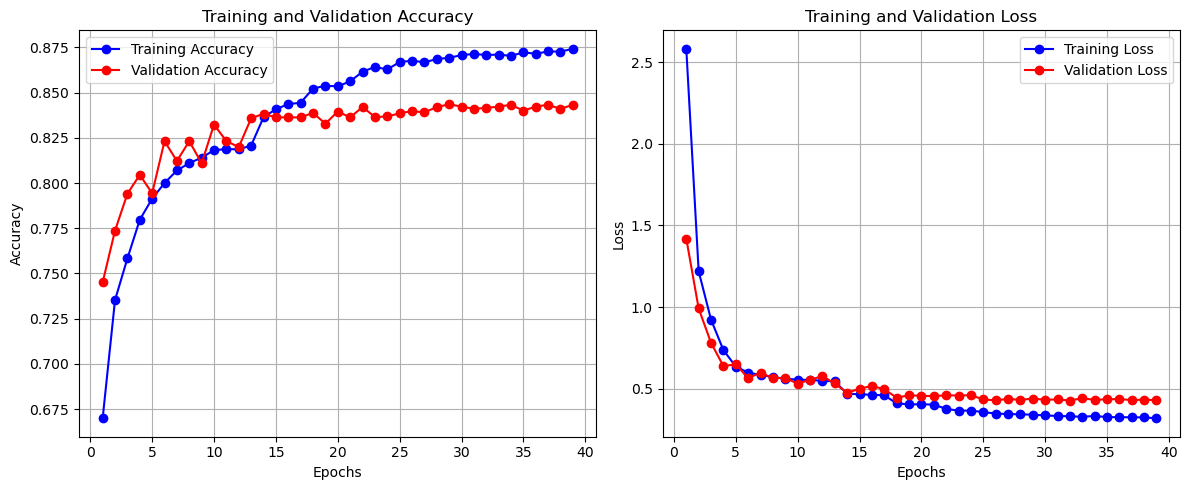


FINAL MODEL EVALUATION ON COMBINED TEST SET

Evaluating model with threshold: 0.3


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 320, 320, 3))
  warnings.warn(msg)


471/524 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step

Premature end of JPEG file


475/524 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step

Premature end of JPEG file


482/524 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step

Premature end of JPEG file
Premature end of JPEG file


486/524 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step

Premature end of JPEG file


492/524 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step

Premature end of JPEG file


524/524 ━━━━━━━━━━━━━━━━━━━━ 105s 178ms/step
True Positives: 1468
True Negatives: 1864
False Positives: 598
False Negatives: 257
Accuracy: 79.58%
Precision: 0.71
Recall: 0.85
F1-Score: 0.77
Cohen's Kappa: 0.59
------------------------------

Evaluating model with threshold: 0.4
471/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


475/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


481/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file
Premature end of JPEG file


485/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


493/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


524/524 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step
True Positives: 1345
True Negatives: 2127
False Positives: 335
False Negatives: 380
Accuracy: 82.92%
Precision: 0.80
Recall: 0.78
F1-Score: 0.79
Cohen's Kappa: 0.65
------------------------------

Evaluating model with threshold: 0.46
471/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


475/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


481/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file
Premature end of JPEG file


485/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


493/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


524/524 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step
True Positives: 1245
True Negatives: 2230
False Positives: 232
False Negatives: 480
Accuracy: 82.99%
Precision: 0.84
Recall: 0.72
F1-Score: 0.78
Cohen's Kappa: 0.64
------------------------------

Evaluating model with threshold: 0.5
471/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


475/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


481/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file
Premature end of JPEG file


485/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


493/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


524/524 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step
True Positives: 1212
True Negatives: 2260
False Positives: 202
False Negatives: 513
Accuracy: 82.92%
Precision: 0.86
Recall: 0.70
F1-Score: 0.77
Cohen's Kappa: 0.64
------------------------------

Evaluating model with threshold: 0.6
471/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


475/524 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step

Premature end of JPEG file


481/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file
Premature end of JPEG file


485/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


492/524 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step

Premature end of JPEG file


524/524 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step
True Positives: 1148
True Negatives: 2309
False Positives: 153
False Negatives: 577
Accuracy: 82.57%
Precision: 0.88
Recall: 0.67
F1-Score: 0.76
Cohen's Kappa: 0.63
------------------------------

Best threshold: 0.4 (F1-Score: 0.79)

Training completed! Best model saved as 'combined_model_best.h5'
Final dataset composition:
- Training: 42373 images
- Validation: 4026 images
- Test: 4187 images


In [1]:


# Create model
model = create_model()
print(f"\nModel created with {model.count_params():,} parameters")

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                               min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, 
                             restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    "combined_model_best.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train Model
print(f"\nStarting training for {EPOCHS} epochs...")
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint],
    verbose=1
)

# Save history
with open('combined_training_history.json', 'w') as f:
    json.dump(history.history, f)

# Plot training history
plot_training_history('combined_training_history.json')



In [35]:
# Evaluate model on test set
model=load_model("combined_model_best.h5")
if len(test_paths) > 0:
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION ON COMBINED TEST SET")
    print("="*50)

    # Test with different thresholds
    thresholds = [0.3, 0.4, 0.46, 0.5, 0.6]
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        accuracy, precision, recall, f1_score, kappa = evaluate_model(
            model, test_generator, test_labels, threshold
        )
        if f1_score > best_f1:
            best_f1 = f1_score
            best_threshold = threshold
        print("-" * 30)

    print(f"\nBest threshold: {best_threshold} (F1-Score: {best_f1:.2f})")
else:
    print("No test data available for evaluation")

print(f"\nTraining completed! Best model saved as 'combined_model_best.h5'")
print(f"Final dataset composition:")
print(f"- Training: {len(train_paths)} images")
print(f"- Validation: {len(valid_paths)} images") 
print(f"- Test: {len(test_paths)} images")


/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



FINAL MODEL EVALUATION ON COMBINED TEST SET

Evaluating model with threshold: 0.3
241/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


245/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


251/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file
Premature end of JPEG file


255/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


263/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


294/294 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step
True Positives: 853
True Negatives: 1067
False Positives: 298
False Negatives: 129
Accuracy: 81.81%
Precision: 0.74
Recall: 0.87
F1-Score: 0.80
Cohen's Kappa: 0.63
------------------------------

Evaluating model with threshold: 0.4
241/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


245/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


251/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file
Premature end of JPEG file


255/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


263/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step
True Positives: 791
True Negatives: 1197
False Positives: 168
False Negatives: 191
Accuracy: 84.70%
Precision: 0.82
Recall: 0.81
F1-Score: 0.82
Cohen's Kappa: 0.68
------------------------------

Evaluating model with threshold: 0.46
241/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


245/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


251/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file
Premature end of JPEG file


255/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


263/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step
True Positives: 735
True Negatives: 1248
False Positives: 117
False Negatives: 247
Accuracy: 84.49%
Precision: 0.86
Recall: 0.75
F1-Score: 0.80
Cohen's Kappa: 0.68
------------------------------

Evaluating model with threshold: 0.5
241/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


245/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


251/294 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

Premature end of JPEG file
Premature end of JPEG file


255/294 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

Premature end of JPEG file


263/294 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

Premature end of JPEG file


294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step
True Positives: 713
True Negatives: 1265
False Positives: 100
False Negatives: 269
Accuracy: 84.28%
Precision: 0.88
Recall: 0.73
F1-Score: 0.79
Cohen's Kappa: 0.67
------------------------------

Evaluating model with threshold: 0.6
241/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


245/294 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

Premature end of JPEG file


251/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file
Premature end of JPEG file


255/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


263/294 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

Premature end of JPEG file


294/294 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step
True Positives: 677
True Negatives: 1291
False Positives: 74
False Negatives: 305
Accuracy: 83.85%
Precision: 0.90
Recall: 0.69
F1-Score: 0.78
Cohen's Kappa: 0.66
------------------------------

Best threshold: 0.4 (F1-Score: 0.82)

Training completed! Best model saved as 'combined_model_best.h5'
Final dataset composition:
- Training: 44213 images
- Validation: 4026 images
- Test: 2347 images
